In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import msBO
from msBO import plot_msGP_over_states
from msBO.utils import plot_2D_projection
from msBO import construct_machineIO as mIO
from pprint import pprint

In [2]:
import warnings
from contextlib import contextmanager

@contextmanager
def capture_warnings():
    warnings.simplefilter("always")
    yield
    with warnings.catch_warnings(record=True) as ws:
        for w in ws:
            print(w.message)
            print(f"{w.filename}, line {w.lineno}")

In [3]:
timespan_for_average = 2    # sec  
additional_wait_after_powersupply_ramp  = 0.2 # sec

In [4]:
n_init = 4
n_eval = 4
beta = 4

In [5]:
n_control = 2
n_obj = 4
n_state = 2

control_CSETs = [f'PSC{i}:I_CSET' for i in range(n_control)]
control_RDs   = [f'PSC{i}:I_RD' for i in range(n_control)]
control_tols  = [0.1]*len(control_CSETs)
control_min   = [0.0]*len(control_CSETs)
control_max   = [1.0]*len(control_CSETs)

In [6]:
iCSET = 0
refCSET = control_CSETs[iCSET]
control_couplings = {refCSET: {'CSETs' : [f'C{i}:I_CSET' for i in range(3)]}
                    }
assert np.all(['_CSET' in pv for pv in control_couplings[refCSET]['CSETs']])
control_couplings[refCSET]['RDs'] = [pv.replace('_CSET','_RD') for pv in control_couplings[refCSET]['CSETs']]
control_couplings[refCSET]['coeffs'] = [0.5,0.5,1.0]
control_couplings[refCSET]['tols'] = [0.5]*3
pprint(control_couplings)      

{'PSC0:I_CSET': {'CSETs': ['C0:I_CSET', 'C1:I_CSET', 'C2:I_CSET'],
                 'RDs': ['C0:I_RD', 'C1:I_RD', 'C2:I_RD'],
                 'coeffs': [0.5, 0.5, 1.0],
                 'tols': [0.5, 0.5, 0.5]}}


In [7]:
n_state_PV = 1
n_state = 2

state_CSETs   = [f'SLIT{i}:POS_CSET' for i in range(n_state_PV)]
state_RDs     = [f'SLIT{i}:POS_RD' for i in range(n_state_PV)]
state_tols    = [0.1]*len(state_CSETs)
state_vals    = [[-16],[16]]
state_names   = [f'Ca{19+i}+' for i in range(n_state)]
objective_PVs = [f'BPM{i}:XPOS_RD' for i in range(n_obj)]
monitor_PVs   = []                              

In [8]:
control_couplings_CSETs = []
control_couplings_RDs = []
for pv, values in control_couplings.items():
    control_couplings_CSETs.extend(values['CSETs'])
    control_couplings_RDs.extend(values['RDs'])

with capture_warnings():
    vm = msBO.virtual_machineIO.VM( 
        control_CSETs = control_CSETs + state_CSETs + control_couplings_CSETs,
        control_RDs = control_RDs + state_RDs + control_couplings_RDs,
        monitor_PVs= objective_PVs + monitor_PVs,
        control_min= control_min + [0]*n_state_PV + [0]*len(control_couplings_CSETs),
        control_max= control_max + [n_state-1]*n_state_PV  + [1]*len(control_couplings_CSETs),
        monitor_min= [-4]*(len(objective_PVs)+len(monitor_PVs)),
        monitor_max= [ 4]*(len(objective_PVs)+len(monitor_PVs)),
    )

with capture_warnings():
    machineIO = msBO.construct_machineIO.construct_machineIO(
        virtual_machineIO=vm,
        fetch_data_time_span = 0.4,
        set_manually=False)

In [9]:
# av,df = machineIO.fetch_data(objective_PVs)
# df

In [10]:
class objective_constructor:
    def __init__(self, n_obj=None, y_tol=None):
        if not isinstance(y_tol,torch.Tensor):
            self.y_tol = torch.tensor(y_tol)
        else:
            self.y_tol = y_tol
        
    def __call__(self, y):
        # Define shape_padding based on the dimensions of y, with '1's for broadcasting
        shape_padding = tuple(1 for _ in range(y.ndim - 1))  # y must be shape of (*, n_state, n_obj)
        obj = torch.mean(1 - torch.std(y / self.y_tol.view(*shape_padding, -1), dim=-2), dim=-1)
        return obj

multi_state_objective_fn = objective_constructor(y_tol = [1]*n_obj)

In [11]:
with capture_warnings():
    msbo = msBO.MultiStateBO(
        machineIO,
        multi_state_objective_fn = multi_state_objective_fn,
        objective_PVs = objective_PVs,
        control_CSETs = control_CSETs,
        control_RDs   = control_RDs,
        control_tols  = control_tols,
        control_min   = control_min,
        control_max   = control_max,
        state_CSETs   = state_CSETs,
        state_RDs     = state_RDs,
        state_tols    = state_tols,
        state_vals    = state_vals,
        state_names   = state_names,
        monitor_PVs   = monitor_PVs,
        control_couplings = control_couplings,
        local_optimization = False,
        local_bound_size   = None,
)

with capture_warnings():
    msbo.init(n_init)
control_values = msbo.machineIO.history['set_order'][control_CSETs].iloc [:1].values

Evaluator_init: control_couplings {'PSC0:I_CSET': {'CSETs': ['C0:I_CSET', 'C1:I_CSET', 'C2:I_CSET'], 'RDs': ['C0:I_RD', 'C1:I_RD', 'C2:I_RD'], 'coeffs': [0.5, 0.5, 1.0], 'tols': [0.5, 0.5, 0.5]}}
Evaluator_init:self.control_couplings {'PSC0:I_CSET': {'CSETs': ['C0:I_CSET', 'C1:I_CSET', 'C2:I_CSET'], 'RDs': ['C0:I_RD', 'C1:I_RD', 'C2:I_RD'], 'coeffs': [0.5, 0.5, 1.0], 'tols': [0.5, 0.5, 0.5]}}
_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.4717584213607052
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:16.780281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471773,0.304461,-15.999920,0.236449,0.236150,0.472141,-4.799428,-4.063990,-1.762888,2.194409,Ca19+
2025-01-30 14:46:16.980281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472209,0.305254,-15.999541,0.236744,0.236225,0.471806,-4.796764,-4.064243,-1.761595,2.192642,Ca19+
2025-01-30 14:46:17.180281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472571,0.304471,-15.999742,0.236586,0.235959,0.472659,-4.798988,-4.061399,-1.762187,2.193802,Ca19+
2025-01-30 14:46:17.380281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472004,0.305102,-15.999598,0.235969,0.236037,0.472267,-4.799456,-4.064401,-1.763046,2.194169,Ca19+
2025-01-30 14:46:17.580281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472747,0.304416,-15.999919,0.236849,0.236846,0.472734,-4.798359,-4.061786,-1.763606,2.192127,Ca19+
2025-01-30 14:46:17.780281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471772,0.305044,-15.999478,0.236268,0.236120,0.472079,-4.799453,-4.065430,-1.762532,2.194241,Ca19+
2025-01-30 14:46:17.980281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472184,0.304719,-15.999941,0.236514,0.236750,0.472433,-4.798986,-4.063586,-1.764114,2.192836,Ca19+
2025-01-30 14:46:18.180281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472160,0.304367,-15.999024,0.235979,0.236531,0.471879,-4.798618,-4.067373,-1.761376,2.194026,Ca19+
2025-01-30 14:46:18.380281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472083,0.304944,-15.999049,0.236327,0.236141,0.471851,-4.798215,-4.066294,-1.760918,2.193877,Ca19+
2025-01-30 14:46:18.580281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471815,0.304351,-15.999816,0.236308,0.236150,0.472293,-4.800082,-4.064163,-1.762967,2.194719,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:18.780281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472164,0.304715,-15.999861,0.236335,0.236589,0.472300,-4.798792,-4.063937,-1.763671,2.193153,Ca19+
2025-01-30 14:46:18.980281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471961,0.304678,-15.999527,0.236430,0.236416,0.472605,-4.800742,-4.064575,-1.763369,2.194153,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.6008196091279387
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:19.180281,0.60082,0.368853,-16.0,0.30041,0.30041,0.60082,0.601245,0.368906,-15.999117,0.300728,0.301068,0.601615,-4.556508,-3.408496,-1.870390,1.980280,Ca19+
2025-01-30 14:46:19.380281,0.60082,0.368853,-16.0,0.30041,0.30041,0.60082,0.600985,0.369759,-15.999692,0.300418,0.301406,0.601552,-4.555796,-3.407186,-1.872803,1.979212,Ca19+
2025-01-30 14:46:19.580281,0.60082,0.368853,-16.0,0.30041,0.30041,0.60082,0.601057,0.369711,-15.999920,0.301081,0.300490,0.600857,-4.553215,-3.405500,-1.869820,1.978855,Ca19+
2025-01-30 14:46:19.780281,0.60082,0.368853,-16.0,0.30041,0.30041,0.60082,0.601700,0.369345,-15.999303,0.301027,0.301117,0.600883,-4.552839,-3.407610,-1.869515,1.977553,Ca19+
2025-01-30 14:46:19.980281,0.60082,0.368853,-16.0,0.30041,0.30041,0.60082,0.601445,0.369798,-15.999658,0.301005,0.300627,0.600937,-4.552567,-3.405462,-1.869641,1.978163,Ca19+
2025-01-30 14:46:20.180281,0.60082,0.368853,-16.0,0.30041,0.30041,0.60082,0.600868,0.369124,-15.999798,0.301012,0.300428,0.601109,-4.555105,-3.406392,-1.869747,1.980414,Ca19+
2025-01-30 14:46:20.380281,0.60082,0.368853,-16.0,0.30041,0.30041,0.60082,0.601479,0.369053,-15.999600,0.300891,0.300780,0.601038,-4.553663,-3.406278,-1.869761,1.979041,Ca19+
2025-01-30 14:46:20.580281,0.60082,0.368853,-16.0,0.30041,0.30041,0.60082,0.601214,0.369009,-15.999480,0.301071,0.300439,0.601090,-4.554577,-3.406811,-1.868908,1.979954,Ca19+
2025-01-30 14:46:20.780281,0.60082,0.368853,-16.0,0.30041,0.30041,0.60082,0.601364,0.369360,-15.999403,0.301100,0.300861,0.601120,-4.553899,-3.407033,-1.869521,1.978795,Ca19+
2025-01-30 14:46:20.980281,0.60082,0.368853,-16.0,0.30041,0.30041,0.60082,0.601637,0.369541,-15.999030,0.301155,0.301345,0.601295,-4.553711,-3.408027,-1.869725,1.977825,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:21.180281,0.60082,0.368853,-16.0,0.30041,0.30041,0.60082,0.601032,0.369021,-15.999394,0.301194,0.300463,0.601365,-4.555491,-3.406923,-1.868952,1.980646,Ca19+
2025-01-30 14:46:21.380281,0.60082,0.368853,-16.0,0.30041,0.30041,0.60082,0.601090,0.369505,-15.999938,0.300917,0.300824,0.601760,-4.554683,-3.403612,-1.871278,1.980403,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.4198976634070277
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:21.580281,0.419898,0.136833,-16.0,0.209949,0.209949,0.419898,0.420027,0.137271,-15.999972,0.210567,0.209989,0.420541,-4.826727,-4.233497,-1.561847,2.438008,Ca19+
2025-01-30 14:46:21.780281,0.419898,0.136833,-16.0,0.209949,0.209949,0.419898,0.419955,0.137608,-15.999827,0.210365,0.210919,0.419922,-4.823352,-4.236038,-1.562039,2.436670,Ca19+
2025-01-30 14:46:21.980281,0.419898,0.136833,-16.0,0.209949,0.209949,0.419898,0.420393,0.137109,-15.999124,0.210341,0.210640,0.420662,-4.826076,-4.235779,-1.560887,2.437730,Ca19+
2025-01-30 14:46:22.180281,0.419898,0.136833,-16.0,0.209949,0.209949,0.419898,0.419903,0.137197,-15.999090,0.210063,0.210364,0.420840,-4.828410,-4.236167,-1.561650,2.439144,Ca19+
2025-01-30 14:46:22.380281,0.419898,0.136833,-16.0,0.209949,0.209949,0.419898,0.420844,0.137215,-15.999818,0.210863,0.210385,0.420885,-4.826069,-4.232892,-1.561707,2.436293,Ca19+
2025-01-30 14:46:22.580281,0.419898,0.136833,-16.0,0.209949,0.209949,0.419898,0.420592,0.137646,-15.999839,0.210031,0.210600,0.420420,-4.824014,-4.234326,-1.562213,2.436632,Ca19+
2025-01-30 14:46:22.780281,0.419898,0.136833,-16.0,0.209949,0.209949,0.419898,0.420405,0.136943,-15.999312,0.210803,0.210333,0.420112,-4.823430,-4.234744,-1.559067,2.437440,Ca19+
2025-01-30 14:46:22.980281,0.419898,0.136833,-16.0,0.209949,0.209949,0.419898,0.420699,0.137497,-15.999782,0.210697,0.210810,0.420125,-4.822316,-4.234364,-1.561033,2.435617,Ca19+
2025-01-30 14:46:23.180281,0.419898,0.136833,-16.0,0.209949,0.209949,0.419898,0.420358,0.137310,-15.999850,0.210743,0.210238,0.419901,-4.822368,-4.233742,-1.559988,2.436851,Ca19+
2025-01-30 14:46:23.380281,0.419898,0.136833,-16.0,0.209949,0.209949,0.419898,0.420667,0.137146,-15.999847,0.210045,0.210567,0.420354,-4.823707,-4.234355,-1.561507,2.436834,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:23.580281,0.419898,0.136833,-16.0,0.209949,0.209949,0.419898,0.420657,0.137196,-15.999403,0.210229,0.210635,0.420663,-4.825274,-4.234938,-1.561312,2.437116,Ca19+
2025-01-30 14:46:23.780281,0.419898,0.136833,-16.0,0.209949,0.209949,0.419898,0.419943,0.137155,-15.999722,0.210708,0.210177,0.420374,-4.826130,-4.234432,-1.561122,2.437994,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.05277284514158964
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:23.980281,0.052773,0.568995,-16.0,0.026386,0.026386,0.052773,0.053105,0.569304,-15.999393,0.027385,0.026851,0.052815,-4.149735,-4.612875,-1.915986,2.825779,Ca19+
2025-01-30 14:46:24.180281,0.052773,0.568995,-16.0,0.026386,0.026386,0.052773,0.053769,0.569792,-15.999102,0.026841,0.027185,0.052950,-4.147500,-4.612533,-1.915875,2.825424,Ca19+
2025-01-30 14:46:24.380281,0.052773,0.568995,-16.0,0.026386,0.026386,0.052773,0.053330,0.569032,-15.999820,0.026614,0.027044,0.052955,-4.147210,-4.612329,-1.916879,2.825418,Ca19+
2025-01-30 14:46:24.580281,0.052773,0.568995,-16.0,0.026386,0.026386,0.052773,0.053459,0.569588,-15.999254,0.026838,0.026717,0.053446,-4.151392,-4.612594,-1.915771,2.826417,Ca19+
2025-01-30 14:46:24.780281,0.052773,0.568995,-16.0,0.026386,0.026386,0.052773,0.053018,0.569462,-15.999099,0.026996,0.026529,0.052832,-4.150611,-4.612753,-1.915472,2.826621,Ca19+
2025-01-30 14:46:24.980281,0.052773,0.568995,-16.0,0.026386,0.026386,0.052773,0.053338,0.569157,-15.999475,0.027292,0.026992,0.053548,-4.151513,-4.612899,-1.916143,2.826122,Ca19+
2025-01-30 14:46:25.180281,0.052773,0.568995,-16.0,0.026386,0.026386,0.052773,0.053470,0.569430,-15.999560,0.027049,0.027172,0.052898,-4.147683,-4.612644,-1.916589,2.825088,Ca19+
2025-01-30 14:46:25.380281,0.052773,0.568995,-16.0,0.026386,0.026386,0.052773,0.052853,0.569813,-15.999167,0.027337,0.027084,0.053353,-4.152446,-4.613997,-1.917246,2.826038,Ca19+
2025-01-30 14:46:25.580281,0.052773,0.568995,-16.0,0.026386,0.026386,0.052773,0.052974,0.569070,-15.999981,0.026807,0.026748,0.052879,-4.148871,-4.612532,-1.917115,2.825525,Ca19+
2025-01-30 14:46:25.780281,0.052773,0.568995,-16.0,0.026386,0.026386,0.052773,0.053330,0.569737,-15.999010,0.026478,0.026657,0.053149,-4.150246,-4.612619,-1.915748,2.826672,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:25.980281,0.052773,0.568995,-16.0,0.026386,0.026386,0.052773,0.052799,0.569144,-15.999322,0.026748,0.027320,0.052817,-4.147667,-4.613475,-1.917464,2.825872,Ca19+
2025-01-30 14:46:26.180281,0.052773,0.568995,-16.0,0.026386,0.026386,0.052773,0.053367,0.569935,-15.999256,0.026916,0.026535,0.052840,-4.150086,-4.612479,-1.915704,2.825875,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.4717584213607052
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:26.380281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472708,0.304301,16.000167,0.236586,0.236767,0.471961,-0.715729,-2.808294,2.708512,-0.079750,Ca20+
2025-01-30 14:46:26.580281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.471951,0.305178,16.000715,0.235978,0.236232,0.471910,-0.714486,-2.805786,2.710410,-0.076898,Ca20+
2025-01-30 14:46:26.780281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472494,0.305018,16.000072,0.236562,0.236869,0.472300,-0.720481,-2.810834,2.706824,-0.077441,Ca20+
2025-01-30 14:46:26.980281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472673,0.305041,16.000177,0.236750,0.236541,0.472655,-0.724251,-2.811729,2.706471,-0.074475,Ca20+
2025-01-30 14:46:27.180281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472110,0.304696,16.000985,0.236335,0.235879,0.472448,-0.718590,-2.806013,2.710349,-0.072945,Ca20+
2025-01-30 14:46:27.380281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472657,0.304351,16.000557,0.236484,0.236006,0.472593,-0.720271,-2.808075,2.709034,-0.074729,Ca20+
2025-01-30 14:46:27.580281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472258,0.304442,16.000808,0.236432,0.236106,0.472641,-0.719987,-2.807369,2.709324,-0.073631,Ca20+
2025-01-30 14:46:27.780281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472111,0.304306,16.000663,0.236669,0.236407,0.472467,-0.719186,-2.807020,2.709117,-0.074111,Ca20+
2025-01-30 14:46:27.980281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.471844,0.304943,16.000833,0.236268,0.235960,0.472233,-0.717496,-2.805327,2.710515,-0.073360,Ca20+
2025-01-30 14:46:28.180281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472396,0.304609,16.000930,0.236862,0.236679,0.471791,-0.714858,-2.806701,2.709840,-0.076366,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:28.380281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472073,0.304957,16.000638,0.236018,0.236747,0.472522,-0.718629,-2.809390,2.707969,-0.077194,Ca20+
2025-01-30 14:46:28.580281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472731,0.305030,16.000822,0.236849,0.236707,0.472148,-0.719184,-2.810062,2.708062,-0.075667,Ca20+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.6008196091279387
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:28.780281,0.60082,0.368853,16.0,0.30041,0.30041,0.60082,0.601188,0.369072,16.000095,0.300808,0.301131,0.601487,-2.006109,-3.876415,2.097530,0.057141,Ca20+
2025-01-30 14:46:28.980281,0.60082,0.368853,16.0,0.30041,0.30041,0.60082,0.601177,0.369629,16.000725,0.301197,0.300742,0.601333,-2.007877,-3.875570,2.098979,0.062018,Ca20+
2025-01-30 14:46:29.180281,0.60082,0.368853,16.0,0.30041,0.30041,0.60082,0.601359,0.369065,16.000346,0.301006,0.301271,0.601771,-2.007983,-3.877804,2.096818,0.057984,Ca20+
2025-01-30 14:46:29.380281,0.60082,0.368853,16.0,0.30041,0.30041,0.60082,0.601590,0.369065,16.000176,0.300547,0.301027,0.600940,-2.001568,-3.875660,2.098211,0.053861,Ca20+
2025-01-30 14:46:29.580281,0.60082,0.368853,16.0,0.30041,0.30041,0.60082,0.601075,0.369668,16.000542,0.300961,0.300985,0.601497,-2.007878,-3.876568,2.098163,0.060233,Ca20+
2025-01-30 14:46:29.780281,0.60082,0.368853,16.0,0.30041,0.30041,0.60082,0.601603,0.369029,16.000795,0.300931,0.301324,0.601092,-2.002443,-3.876562,2.098046,0.055649,Ca20+
2025-01-30 14:46:29.980281,0.60082,0.368853,16.0,0.30041,0.30041,0.60082,0.601798,0.369278,16.000983,0.301312,0.300558,0.601018,-2.005347,-3.875044,2.099471,0.060723,Ca20+
2025-01-30 14:46:30.180281,0.60082,0.368853,16.0,0.30041,0.30041,0.60082,0.601490,0.369498,16.000049,0.301223,0.301237,0.601180,-2.006539,-3.877380,2.097005,0.057465,Ca20+
2025-01-30 14:46:30.380281,0.60082,0.368853,16.0,0.30041,0.30041,0.60082,0.601418,0.369832,16.000651,0.300655,0.301391,0.601154,-2.003775,-3.877876,2.097510,0.055348,Ca20+
2025-01-30 14:46:30.580281,0.60082,0.368853,16.0,0.30041,0.30041,0.60082,0.601044,0.369243,16.000514,0.300463,0.301261,0.600845,-2.000218,-3.874923,2.098992,0.054601,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:30.780281,0.60082,0.368853,16.0,0.30041,0.30041,0.60082,0.601094,0.368870,16.000494,0.300431,0.300948,0.600986,-2.000781,-3.873912,2.099522,0.055569,Ca20+
2025-01-30 14:46:30.980281,0.60082,0.368853,16.0,0.30041,0.30041,0.60082,0.601173,0.369493,16.000553,0.301162,0.301101,0.601115,-2.005517,-3.875858,2.098469,0.059354,Ca20+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.4198976634070277
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:31.180281,0.419898,0.136833,16.0,0.209949,0.209949,0.419898,0.420236,0.137175,16.000618,0.210217,0.210059,0.420706,0.284580,-2.013425,3.116805,-0.472398,Ca20+
2025-01-30 14:46:31.380281,0.419898,0.136833,16.0,0.209949,0.209949,0.419898,0.420026,0.137746,16.000733,0.210615,0.210826,0.419900,0.288648,-2.012486,3.117220,-0.474312,Ca20+
2025-01-30 14:46:31.580281,0.419898,0.136833,16.0,0.209949,0.209949,0.419898,0.420385,0.137030,16.000868,0.210701,0.210301,0.420038,0.288871,-2.011492,3.118183,-0.473938,Ca20+
2025-01-30 14:46:31.780281,0.419898,0.136833,16.0,0.209949,0.209949,0.419898,0.420139,0.137765,16.000090,0.210634,0.210526,0.420044,0.285711,-2.013253,3.116238,-0.473551,Ca20+
2025-01-30 14:46:31.980281,0.419898,0.136833,16.0,0.209949,0.209949,0.419898,0.419948,0.137595,16.000730,0.210857,0.210672,0.419959,0.287653,-2.011973,3.117422,-0.472638,Ca20+
2025-01-30 14:46:32.180281,0.419898,0.136833,16.0,0.209949,0.209949,0.419898,0.420784,0.137533,16.000606,0.210521,0.210305,0.420315,0.285105,-2.014953,3.116270,-0.473867,Ca20+
2025-01-30 14:46:32.380281,0.419898,0.136833,16.0,0.209949,0.209949,0.419898,0.419981,0.137063,16.000289,0.210061,0.210628,0.420340,0.288098,-2.012206,3.116706,-0.476011,Ca20+
2025-01-30 14:46:32.580281,0.419898,0.136833,16.0,0.209949,0.209949,0.419898,0.420207,0.137118,16.000617,0.210588,0.210188,0.420546,0.284642,-2.013016,3.116868,-0.471724,Ca20+
2025-01-30 14:46:32.780281,0.419898,0.136833,16.0,0.209949,0.209949,0.419898,0.419898,0.137085,16.000712,0.210866,0.210942,0.420886,0.281846,-2.014881,3.115024,-0.470404,Ca20+
2025-01-30 14:46:32.980281,0.419898,0.136833,16.0,0.209949,0.209949,0.419898,0.420361,0.137007,16.000360,0.210658,0.210549,0.420523,0.284292,-2.014036,3.115783,-0.473226,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:33.180281,0.419898,0.136833,16.0,0.209949,0.209949,0.419898,0.420294,0.137587,16.000167,0.210719,0.210118,0.419917,0.286696,-2.012037,3.117342,-0.473178,Ca20+
2025-01-30 14:46:33.380281,0.419898,0.136833,16.0,0.209949,0.209949,0.419898,0.420424,0.137133,16.000837,0.210494,0.210789,0.420188,0.288335,-2.013284,3.116865,-0.475536,Ca20+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.05277284514158964
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:33.580281,0.052773,0.568995,16.0,0.026386,0.026386,0.052773,0.053048,0.569632,16.000913,0.026973,0.026979,0.053134,1.164903,-0.519435,3.513311,-0.363492,Ca20+
2025-01-30 14:46:33.780281,0.052773,0.568995,16.0,0.026386,0.026386,0.052773,0.053657,0.569928,16.000018,0.026671,0.026544,0.053092,1.166489,-0.519416,3.513935,-0.364219,Ca20+
2025-01-30 14:46:33.980281,0.052773,0.568995,16.0,0.026386,0.026386,0.052773,0.053016,0.569760,16.000325,0.026752,0.027171,0.053410,1.163516,-0.520433,3.512396,-0.363649,Ca20+
2025-01-30 14:46:34.180281,0.052773,0.568995,16.0,0.026386,0.026386,0.052773,0.053094,0.569827,16.000476,0.027324,0.026548,0.053064,1.163496,-0.518773,3.512863,-0.361835,Ca20+
2025-01-30 14:46:34.380281,0.052773,0.568995,16.0,0.026386,0.026386,0.052773,0.052891,0.569781,16.000098,0.027213,0.027009,0.053139,1.163088,-0.519809,3.512492,-0.363143,Ca20+
2025-01-30 14:46:34.580281,0.052773,0.568995,16.0,0.026386,0.026386,0.052773,0.053531,0.569018,16.000888,0.026746,0.026682,0.053462,1.166901,-0.519415,3.514899,-0.364276,Ca20+
2025-01-30 14:46:34.780281,0.052773,0.568995,16.0,0.026386,0.026386,0.052773,0.052876,0.569954,16.000723,0.026388,0.026960,0.052870,1.165633,-0.519095,3.513105,-0.364518,Ca20+
2025-01-30 14:46:34.980281,0.052773,0.568995,16.0,0.026386,0.026386,0.052773,0.053134,0.569348,16.000817,0.026561,0.026961,0.053029,1.167211,-0.519277,3.514522,-0.365447,Ca20+
2025-01-30 14:46:35.180281,0.052773,0.568995,16.0,0.026386,0.026386,0.052773,0.053200,0.569559,16.000128,0.026758,0.026974,0.053016,1.166374,-0.519715,3.514079,-0.365395,Ca20+
2025-01-30 14:46:35.380281,0.052773,0.568995,16.0,0.026386,0.026386,0.052773,0.053434,0.569354,16.000839,0.026876,0.027367,0.053249,1.167359,-0.520594,3.514533,-0.365858,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:35.580281,0.052773,0.568995,16.0,0.026386,0.026386,0.052773,0.053732,0.569006,16.000921,0.027006,0.026404,0.052822,1.170047,-0.518205,3.516662,-0.365573,Ca20+
2025-01-30 14:46:35.780281,0.052773,0.568995,16.0,0.026386,0.026386,0.052773,0.053681,0.569859,16.000958,0.026484,0.026870,0.053219,1.167334,-0.519799,3.514054,-0.364505,Ca20+


/home/devuser/.local/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


# after init

In [12]:
candidate = control_values = msbo.machineIO.history['set_order'][control_CSETs].iloc [:1].values
control_values = candidate

In [13]:
# projection_plot(msbo,candidate)

_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.4717584213607052
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:35.980281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472588,0.304495,-15.999639,0.236007,0.236491,0.472460,-4.798668,-4.063577,-1.763093,2.193286,Ca19+
2025-01-30 14:46:36.180281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472441,0.305013,-15.999199,0.235974,0.236635,0.471972,-4.797578,-4.066130,-1.762243,2.192760,Ca19+
2025-01-30 14:46:36.380281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472676,0.305222,-15.999414,0.236715,0.235908,0.472525,-4.798063,-4.061947,-1.761601,2.193008,Ca19+
2025-01-30 14:46:36.580281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471801,0.304308,-15.999357,0.236509,0.236263,0.471862,-4.798998,-4.066193,-1.761335,2.194475,Ca19+
2025-01-30 14:46:36.780281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471874,0.304989,-15.999851,0.235949,0.236174,0.472403,-4.800112,-4.064064,-1.764041,2.194251,Ca19+
2025-01-30 14:46:36.980281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471772,0.305226,-15.999332,0.236328,0.236287,0.472662,-4.801447,-4.065289,-1.763606,2.194339,Ca19+
2025-01-30 14:46:37.180281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472054,0.304371,-15.999272,0.235984,0.235921,0.471880,-4.798720,-4.065699,-1.760958,2.194868,Ca19+
2025-01-30 14:46:37.380281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472690,0.304894,-15.999397,0.236535,0.236005,0.472664,-4.798802,-4.062210,-1.761878,2.193398,Ca19+
2025-01-30 14:46:37.580281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472097,0.305060,-15.999918,0.236102,0.236649,0.472388,-4.799174,-4.064093,-1.764587,2.193017,Ca19+
2025-01-30 14:46:37.780281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472699,0.305129,-15.999564,0.236484,0.236533,0.472159,-4.796734,-4.063409,-1.762403,2.191959,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:37.980281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471908,0.304625,-15.999238,0.236215,0.236188,0.472150,-4.799805,-4.065998,-1.761908,2.194577,Ca19+
2025-01-30 14:46:38.180281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472712,0.304945,-15.999986,0.236470,0.236810,0.472118,-4.796218,-4.062749,-1.763431,2.191434,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.4717584213607052
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:38.380281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472372,0.305044,16.000695,0.236425,0.236742,0.471964,-0.716132,-2.808476,2.708797,-0.077671,Ca20+
2025-01-30 14:46:38.580281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.471978,0.304433,16.000176,0.236542,0.236844,0.472053,-0.716361,-2.806991,2.708679,-0.077717,Ca20+
2025-01-30 14:46:38.780281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.471863,0.305239,16.000742,0.236419,0.236183,0.471879,-0.716205,-2.805493,2.710388,-0.074287,Ca20+
2025-01-30 14:46:38.980281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472687,0.304939,16.000721,0.236420,0.236706,0.472008,-0.716228,-2.809199,2.708634,-0.078408,Ca20+
2025-01-30 14:46:39.180281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472735,0.304438,16.000706,0.236650,0.236629,0.472029,-0.715966,-2.808149,2.709091,-0.077896,Ca20+
2025-01-30 14:46:39.380281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472354,0.304304,16.000521,0.236096,0.236328,0.472531,-0.717752,-2.807715,2.709033,-0.077282,Ca20+
2025-01-30 14:46:39.580281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472387,0.304573,16.000908,0.235897,0.236820,0.471818,-0.710909,-2.806891,2.710032,-0.081581,Ca20+
2025-01-30 14:46:39.780281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472393,0.305263,16.000720,0.236772,0.236661,0.471952,-0.718141,-2.808807,2.708577,-0.075387,Ca20+
2025-01-30 14:46:39.980281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.471819,0.304801,16.000656,0.236724,0.236817,0.472049,-0.717168,-2.806934,2.708991,-0.075109,Ca20+
2025-01-30 14:46:40.180281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.471985,0.304641,16.000094,0.236463,0.236053,0.472203,-0.718634,-2.805812,2.709578,-0.074620,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:40.380281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472454,0.304645,16.000176,0.236463,0.236507,0.472415,-0.719948,-2.809187,2.707875,-0.076642,Ca20+
2025-01-30 14:46:40.580281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472742,0.304933,16.000783,0.236229,0.235980,0.471794,-0.714196,-2.806432,2.710692,-0.077630,Ca20+


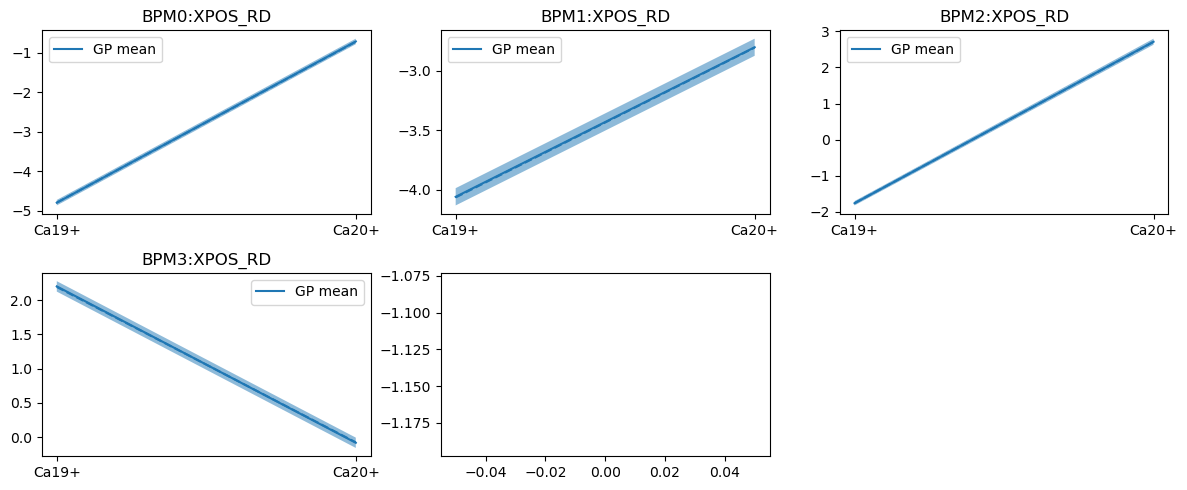

In [14]:
with capture_warnings():
    fig,ax = plot_msGP_over_states(
        msbo.msGP,
        control_values=control_values,
        control_data_labels = ["init"],
        state_names = state_names,
        objective_PVs = objective_PVs,
        multi_state_objective_fn = multi_state_objective_fn,
        CL = 3,
    )
    
    l_ytrue = np.zeros((len(control_values),n_state,n_obj))
    l_obj = np.zeros(len(control_values))

    for i,x in enumerate(control_values):
        for istate in range(n_state):
            future = msbo.evaluator.submit(x,istate=istate)
            df, df_ramp  = msbo.evaluator.get_result(future)
            y = df[objective_PVs].mean().values
            l_ytrue[i,istate,:] = y
        l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

    for i_obj in range(n_obj):
        for i_c in range(len(control_values)):
            ax[i_obj].plot(np.arange(n_state),l_ytrue[i_c,:,i_obj],'--C'+str(i_c))
    ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

# 1st globalBO

In [15]:
with capture_warnings():
    msbo.optimize_global(neval=n_eval, beta=beta)
    candidate = msbo.query_candidate(msbo.control_bounds_botorch, beta=0.0)
    control_values = np.vstack((control_values,candidate))

_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.0
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:40.780281,0.0,1.0,-16.0,0.0,0.0,0.0,0.000553,1.000809,-15.999074,0.000852,0.000809,0.000164,-4.660703,-4.617562,-2.237871,2.467653,Ca19+
2025-01-30 14:46:40.980281,0.0,1.0,-16.0,0.0,0.0,0.0,0.000427,1.000783,-15.999441,0.000046,0.000318,0.000218,-4.660452,-4.617298,-2.238647,2.467549,Ca19+
2025-01-30 14:46:41.180281,0.0,1.0,-16.0,0.0,0.0,0.0,0.000829,1.000847,-15.999838,0.000822,0.000002,0.000632,-4.663560,-4.616343,-2.237360,2.468490,Ca19+
2025-01-30 14:46:41.380281,0.0,1.0,-16.0,0.0,0.0,0.0,0.000361,1.000489,-15.999746,0.000234,0.000013,0.000930,-4.663498,-4.617059,-2.238399,2.469157,Ca19+
2025-01-30 14:46:41.580281,0.0,1.0,-16.0,0.0,0.0,0.0,0.000322,1.000689,-15.999148,0.000151,0.000073,0.000435,-4.661963,-4.617064,-2.237434,2.468626,Ca19+
2025-01-30 14:46:41.780281,0.0,1.0,-16.0,0.0,0.0,0.0,0.000812,1.000302,-15.999107,0.000208,0.000553,0.000722,-4.660463,-4.617786,-2.237781,2.468400,Ca19+
2025-01-30 14:46:41.980281,0.0,1.0,-16.0,0.0,0.0,0.0,0.000227,1.000108,-15.999587,0.000024,0.000804,0.000834,-4.660558,-4.618519,-2.240240,2.468403,Ca19+
2025-01-30 14:46:42.180281,0.0,1.0,-16.0,0.0,0.0,0.0,0.000415,1.000015,-15.999969,0.000829,0.000601,0.000632,-4.661476,-4.617831,-2.239298,2.468781,Ca19+
2025-01-30 14:46:42.380281,0.0,1.0,-16.0,0.0,0.0,0.0,0.000348,1.000940,-15.999588,0.000600,0.000570,0.000035,-4.660841,-4.617289,-2.238961,2.467275,Ca19+
2025-01-30 14:46:42.580281,0.0,1.0,-16.0,0.0,0.0,0.0,0.000879,1.000025,-15.999504,0.000073,0.000949,0.000781,-4.658893,-4.618507,-2.239581,2.467776,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:42.780281,0.0,1.0,-16.0,0.0,0.0,0.0,0.000759,1.000649,-15.999196,0.000719,0.000185,0.000546,-4.662439,-4.616834,-2.23659,2.468747,Ca19+
2025-01-30 14:46:42.980281,0.0,1.0,-16.0,0.0,0.0,0.0,0.000299,1.000069,-15.999451,0.000760,0.000274,0.000091,-4.660525,-4.617422,-2.23762,2.468872,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.5132629440718395
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:43.180281,0.513263,1.0,-16.0,0.256631,0.256631,0.513263,0.513367,1.000104,-15.999520,0.257211,0.257520,0.513748,-4.883568,-4.100352,-2.425924,1.508987,Ca19+
2025-01-30 14:46:43.380281,0.513263,1.0,-16.0,0.256631,0.256631,0.513263,0.513996,1.000117,-15.999712,0.257084,0.256861,0.513922,-4.882320,-4.097152,-2.424552,1.508853,Ca19+
2025-01-30 14:46:43.580281,0.513263,1.0,-16.0,0.256631,0.256631,0.513263,0.513988,1.000625,-15.999508,0.256825,0.257481,0.513850,-4.882502,-4.098767,-2.426351,1.507374,Ca19+
2025-01-30 14:46:43.780281,0.513263,1.0,-16.0,0.256631,0.256631,0.513263,0.513567,1.000349,-15.999878,0.257134,0.256815,0.513924,-4.883434,-4.097796,-2.425112,1.509558,Ca19+
2025-01-30 14:46:43.980281,0.513263,1.0,-16.0,0.256631,0.256631,0.513263,0.514129,1.000436,-15.999414,0.257004,0.257545,0.513511,-4.881796,-4.099062,-2.425815,1.506966,Ca19+
2025-01-30 14:46:44.180281,0.513263,1.0,-16.0,0.256631,0.256631,0.513263,0.513421,1.000345,-15.999422,0.257352,0.256960,0.514192,-4.885338,-4.100498,-2.424963,1.510452,Ca19+
2025-01-30 14:46:44.380281,0.513263,1.0,-16.0,0.256631,0.256631,0.513263,0.513662,1.000753,-15.999627,0.257108,0.257627,0.514048,-4.883110,-4.098686,-2.426840,1.507802,Ca19+
2025-01-30 14:46:44.580281,0.513263,1.0,-16.0,0.256631,0.256631,0.513263,0.513317,1.000763,-15.999987,0.256737,0.256889,0.513401,-4.883849,-4.099335,-2.426264,1.509020,Ca19+
2025-01-30 14:46:44.780281,0.513263,1.0,-16.0,0.256631,0.256631,0.513263,0.513390,1.000687,-15.999298,0.257303,0.257323,0.514154,-4.885590,-4.101517,-2.425970,1.509668,Ca19+
2025-01-30 14:46:44.980281,0.513263,1.0,-16.0,0.256631,0.256631,0.513263,0.513533,1.000661,-15.999581,0.257618,0.256950,0.513614,-4.884435,-4.100044,-2.424881,1.509501,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:45.180281,0.513263,1.0,-16.0,0.256631,0.256631,0.513263,0.513338,1.000663,-15.999465,0.256655,0.257469,0.513924,-4.884768,-4.101370,-2.427041,1.508844,Ca19+
2025-01-30 14:46:45.380281,0.513263,1.0,-16.0,0.256631,0.256631,0.513263,0.513448,1.000749,-15.999679,0.257004,0.257264,0.514017,-4.884223,-4.099447,-2.426470,1.508916,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 1.0
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:45.580281,1.0,0.0,-16.0,0.5,0.5,1.0,1.000381,0.000432,-15.999694,0.500747,0.500002,1.000699,-4.628759,-2.838820,-1.514178,2.947368,Ca19+
2025-01-30 14:46:45.780281,1.0,0.0,-16.0,0.5,0.5,1.0,1.000214,0.000525,-15.999249,0.500096,0.500295,1.000173,-4.627328,-2.840428,-1.516341,2.947941,Ca19+
2025-01-30 14:46:45.980281,1.0,0.0,-16.0,0.5,0.5,1.0,1.000844,0.000826,-15.999109,0.500800,0.500154,1.000877,-4.625910,-2.837755,-1.513452,2.946990,Ca19+
2025-01-30 14:46:46.180281,1.0,0.0,-16.0,0.5,0.5,1.0,1.000480,0.000823,-15.999225,0.500310,0.500310,1.000732,-4.627079,-2.838348,-1.515161,2.948126,Ca19+
2025-01-30 14:46:46.380281,1.0,0.0,-16.0,0.5,0.5,1.0,1.000763,0.000155,-15.999261,0.500114,0.500505,1.000143,-4.626752,-2.841148,-1.516549,2.947903,Ca19+
2025-01-30 14:46:46.580281,1.0,0.0,-16.0,0.5,0.5,1.0,1.000009,0.000188,-15.999238,0.500549,0.500706,1.000698,-4.630585,-2.842771,-1.515747,2.948705,Ca19+
2025-01-30 14:46:46.780281,1.0,0.0,-16.0,0.5,0.5,1.0,1.000272,0.000015,-15.999512,0.500616,0.500145,1.000562,-4.629513,-2.841325,-1.514894,2.947771,Ca19+
2025-01-30 14:46:46.980281,1.0,0.0,-16.0,0.5,0.5,1.0,1.000673,0.000415,-15.999995,0.500116,0.500689,1.000673,-4.629423,-2.838597,-1.516786,2.949145,Ca19+
2025-01-30 14:46:47.180281,1.0,0.0,-16.0,0.5,0.5,1.0,1.000233,0.000513,-15.999900,0.500506,0.500954,1.000159,-4.629883,-2.840928,-1.516951,2.948075,Ca19+
2025-01-30 14:46:47.380281,1.0,0.0,-16.0,0.5,0.5,1.0,1.000727,0.000269,-15.999111,0.500236,0.500894,1.000833,-4.628427,-2.841186,-1.516190,2.949127,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:47.580281,1.0,0.0,-16.0,0.5,0.5,1.0,1.000302,0.000843,-15.999915,0.500696,0.500767,1.000871,-4.630224,-2.838403,-1.515452,2.948470,Ca19+
2025-01-30 14:46:47.780281,1.0,0.0,-16.0,0.5,0.5,1.0,1.000382,0.000726,-15.999647,0.500220,0.500371,1.000051,-4.627134,-2.838956,-1.516414,2.947511,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 1.0
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:47.980281,1.0,1.0,-16.0,0.5,0.5,1.0,1.000696,1.000704,-15.999821,0.500448,0.500117,1.000554,-3.903869,-0.532941,-1.978934,1.008409,Ca19+
2025-01-30 14:46:48.180281,1.0,1.0,-16.0,0.5,0.5,1.0,1.000354,1.000408,-15.999287,0.500407,0.500319,1.000676,-3.904431,-0.536436,-1.978911,1.009820,Ca19+
2025-01-30 14:46:48.380281,1.0,1.0,-16.0,0.5,0.5,1.0,1.000717,1.000036,-15.999061,0.500308,0.500620,1.000625,-3.903378,-0.536373,-1.978890,1.010747,Ca19+
2025-01-30 14:46:48.580281,1.0,1.0,-16.0,0.5,0.5,1.0,1.000513,1.000984,-15.999740,0.500829,0.500727,1.000929,-3.905162,-0.532016,-1.979507,1.008084,Ca19+
2025-01-30 14:46:48.780281,1.0,1.0,-16.0,0.5,0.5,1.0,1.000230,1.000988,-15.999378,0.500398,0.500485,1.000242,-3.903558,-0.536162,-1.980235,1.008489,Ca19+
2025-01-30 14:46:48.980281,1.0,1.0,-16.0,0.5,0.5,1.0,1.000498,1.000771,-15.999801,0.500314,0.500689,1.000378,-3.903103,-0.533167,-1.979634,1.008754,Ca19+
2025-01-30 14:46:49.180281,1.0,1.0,-16.0,0.5,0.5,1.0,1.000242,1.000275,-15.999881,0.500116,0.500602,1.000578,-3.903555,-0.534213,-1.978497,1.010151,Ca19+
2025-01-30 14:46:49.380281,1.0,1.0,-16.0,0.5,0.5,1.0,1.000859,1.000580,-15.999462,0.500150,0.500111,1.000307,-3.902751,-0.534593,-1.979383,1.009125,Ca19+
2025-01-30 14:46:49.580281,1.0,1.0,-16.0,0.5,0.5,1.0,1.000214,1.000021,-15.999722,0.500942,0.500255,1.000266,-3.903814,-0.536325,-1.977845,1.008840,Ca19+
2025-01-30 14:46:49.780281,1.0,1.0,-16.0,0.5,0.5,1.0,1.000501,1.000730,-15.999232,0.500573,0.500337,1.000012,-3.902821,-0.536816,-1.979985,1.008333,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:49.980281,1.0,1.0,-16.0,0.5,0.5,1.0,1.000749,1.000778,-15.999909,0.500436,0.500218,1.000350,-3.903182,-0.532483,-1.979224,1.008061,Ca19+
2025-01-30 14:46:50.180281,1.0,1.0,-16.0,0.5,0.5,1.0,1.000587,1.000049,-15.999892,0.500034,0.500116,1.000075,-3.901978,-0.534829,-1.978208,1.009789,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.6374435387973928
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:50.380281,0.637444,0.843403,16.0,0.318722,0.318722,0.637444,0.638418,0.844291,16.000104,0.319029,0.318932,0.637959,-3.681742,-4.581739,1.504818,0.450856,Ca20+
2025-01-30 14:46:50.580281,0.637444,0.843403,16.0,0.318722,0.318722,0.637444,0.638367,0.844164,16.000479,0.318733,0.319281,0.638173,-3.680338,-4.582421,1.504339,0.448733,Ca20+
2025-01-30 14:46:50.780281,0.637444,0.843403,16.0,0.318722,0.318722,0.637444,0.637739,0.843501,16.000449,0.318981,0.319154,0.637867,-3.679226,-4.580362,1.505637,0.451298,Ca20+
2025-01-30 14:46:50.980281,0.637444,0.843403,16.0,0.318722,0.318722,0.637444,0.637842,0.844263,16.000841,0.318915,0.319638,0.638299,-3.682617,-4.582185,1.503350,0.450168,Ca20+
2025-01-30 14:46:51.180281,0.637444,0.843403,16.0,0.318722,0.318722,0.637444,0.638236,0.844328,16.000731,0.319302,0.319231,0.637674,-3.680958,-4.581159,1.504612,0.451949,Ca20+
2025-01-30 14:46:51.380281,0.637444,0.843403,16.0,0.318722,0.318722,0.637444,0.638199,0.844119,16.000543,0.318979,0.319263,0.638107,-3.681340,-4.581880,1.504421,0.450463,Ca20+
2025-01-30 14:46:51.580281,0.637444,0.843403,16.0,0.318722,0.318722,0.637444,0.637947,0.844008,16.000319,0.319679,0.319690,0.637582,-3.679982,-4.581943,1.504231,0.450574,Ca20+
2025-01-30 14:46:51.780281,0.637444,0.843403,16.0,0.318722,0.318722,0.637444,0.637577,0.843619,16.000043,0.318894,0.318829,0.638130,-3.682362,-4.580039,1.505566,0.452795,Ca20+
2025-01-30 14:46:51.980281,0.637444,0.843403,16.0,0.318722,0.318722,0.637444,0.638024,0.843797,16.000414,0.318861,0.319441,0.638407,-3.681267,-4.582435,1.504244,0.449320,Ca20+
2025-01-30 14:46:52.180281,0.637444,0.843403,16.0,0.318722,0.318722,0.637444,0.638089,0.844045,16.000133,0.319309,0.318750,0.637934,-3.683340,-4.580512,1.505357,0.453950,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:52.380281,0.637444,0.843403,16.0,0.318722,0.318722,0.637444,0.637539,0.843911,16.000348,0.319504,0.319304,0.638166,-3.684779,-4.580936,1.504255,0.454028,Ca20+
2025-01-30 14:46:52.580281,0.637444,0.843403,16.0,0.318722,0.318722,0.637444,0.638057,0.843992,16.000248,0.319500,0.319302,0.637753,-3.681138,-4.581467,1.504737,0.451719,Ca20+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.0
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:52.780281,0.0,0.0,16.0,0.0,0.0,0.0,0.000141,0.000152,16.000106,0.000908,0.000516,0.000693,1.896424,-0.120687,4.093222,-1.152661,Ca20+
2025-01-30 14:46:52.980281,0.0,0.0,16.0,0.0,0.0,0.0,0.000971,0.000879,16.000792,0.000176,0.000756,0.000846,1.897640,-0.121359,4.093399,-1.154232,Ca20+
2025-01-30 14:46:53.180281,0.0,0.0,16.0,0.0,0.0,0.0,0.000254,0.000773,16.000545,0.000839,0.000175,0.000333,1.896213,-0.120698,4.093752,-1.152148,Ca20+
2025-01-30 14:46:53.380281,0.0,0.0,16.0,0.0,0.0,0.0,0.000234,0.000582,16.000365,0.000822,0.000076,0.000851,1.895454,-0.121346,4.093173,-1.151354,Ca20+
2025-01-30 14:46:53.580281,0.0,0.0,16.0,0.0,0.0,0.0,0.000320,0.000625,16.000586,0.000043,0.000421,0.000373,1.896015,-0.120731,4.093104,-1.152797,Ca20+
2025-01-30 14:46:53.780281,0.0,0.0,16.0,0.0,0.0,0.0,0.000935,0.000131,16.000245,0.000842,0.000458,0.000661,1.898625,-0.120734,4.093919,-1.155023,Ca20+
2025-01-30 14:46:53.980281,0.0,0.0,16.0,0.0,0.0,0.0,0.000750,0.000277,16.000193,0.000803,0.000254,0.000986,1.897257,-0.121330,4.093404,-1.153481,Ca20+
2025-01-30 14:46:54.180281,0.0,0.0,16.0,0.0,0.0,0.0,0.000136,0.000613,16.000784,0.000542,0.000645,0.000541,1.895918,-0.120751,4.093308,-1.152079,Ca20+
2025-01-30 14:46:54.380281,0.0,0.0,16.0,0.0,0.0,0.0,0.000190,0.000049,16.000065,0.000605,0.000144,0.000341,1.896338,-0.120401,4.093316,-1.152910,Ca20+
2025-01-30 14:46:54.580281,0.0,0.0,16.0,0.0,0.0,0.0,0.000069,0.000204,16.000055,0.000751,0.000571,0.000156,1.896894,-0.119981,4.093500,-1.153473,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:54.780281,0.0,0.0,16.0,0.0,0.0,0.0,0.000018,0.000311,16.000182,0.000041,0.00027,0.000175,1.895528,-0.120344,4.092875,-1.152567,Ca20+
2025-01-30 14:46:54.980281,0.0,0.0,16.0,0.0,0.0,0.0,0.000526,0.000223,16.000102,0.000234,0.00070,0.000313,1.897696,-0.120273,4.093308,-1.154836,Ca20+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.6936315516323097
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:55.180281,0.693632,1.0,16.0,0.346816,0.346816,0.693632,0.694069,1.000633,16.000649,0.347388,0.347455,0.694189,-4.437020,-4.801490,1.179154,0.478428,Ca20+
2025-01-30 14:46:55.380281,0.693632,1.0,16.0,0.346816,0.346816,0.693632,0.694447,1.000813,16.000447,0.347396,0.347180,0.693660,-4.434581,-4.801185,1.179887,0.478019,Ca20+
2025-01-30 14:46:55.580281,0.693632,1.0,16.0,0.346816,0.346816,0.693632,0.694109,1.000035,16.000473,0.347810,0.347658,0.694312,-4.435792,-4.802412,1.179773,0.478266,Ca20+
2025-01-30 14:46:55.780281,0.693632,1.0,16.0,0.346816,0.346816,0.693632,0.693727,1.000119,16.000864,0.347313,0.347573,0.694451,-4.436984,-4.801347,1.179436,0.478734,Ca20+
2025-01-30 14:46:55.980281,0.693632,1.0,16.0,0.346816,0.346816,0.693632,0.693690,1.000324,16.000070,0.347680,0.347761,0.694176,-4.436550,-4.802228,1.179107,0.477259,Ca20+
2025-01-30 14:46:56.180281,0.693632,1.0,16.0,0.346816,0.346816,0.693632,0.694112,1.000951,16.000243,0.347052,0.347727,0.694431,-4.436703,-4.802708,1.178189,0.475068,Ca20+
2025-01-30 14:46:56.380281,0.693632,1.0,16.0,0.346816,0.346816,0.693632,0.694593,1.000658,16.000018,0.347359,0.347037,0.693766,-4.434018,-4.801681,1.180374,0.477441,Ca20+
2025-01-30 14:46:56.580281,0.693632,1.0,16.0,0.346816,0.346816,0.693632,0.694487,1.000720,16.000506,0.346853,0.347360,0.693747,-4.431788,-4.801683,1.179832,0.474786,Ca20+
2025-01-30 14:46:56.780281,0.693632,1.0,16.0,0.346816,0.346816,0.693632,0.694069,1.000259,16.000865,0.347497,0.347231,0.694322,-4.437660,-4.800985,1.179912,0.480581,Ca20+
2025-01-30 14:46:56.980281,0.693632,1.0,16.0,0.346816,0.346816,0.693632,0.693969,1.000457,16.000134,0.347286,0.347375,0.694351,-4.436991,-4.801890,1.179434,0.477690,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:57.180281,0.693632,1.0,16.0,0.346816,0.346816,0.693632,0.694334,1.000919,16.000073,0.347656,0.347270,0.694295,-4.438990,-4.802118,1.178999,0.479113,Ca20+
2025-01-30 14:46:57.380281,0.693632,1.0,16.0,0.346816,0.346816,0.693632,0.694270,1.000733,16.000730,0.346884,0.347245,0.694097,-4.435164,-4.801170,1.179509,0.477159,Ca20+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.521594768357178
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:57.580281,0.521595,1.0,16.0,0.260797,0.260797,0.521595,0.522375,1.000983,16.000149,0.261314,0.261217,0.521647,-3.808876,-3.949386,1.367214,0.798668,Ca20+
2025-01-30 14:46:57.780281,0.521595,1.0,16.0,0.260797,0.260797,0.521595,0.521785,1.000754,16.000760,0.261159,0.261075,0.522569,-3.815702,-3.947532,1.365690,0.802918,Ca20+
2025-01-30 14:46:57.980281,0.521595,1.0,16.0,0.260797,0.260797,0.521595,0.521804,1.000070,16.000458,0.261231,0.261184,0.522405,-3.811679,-3.948781,1.367500,0.800981,Ca20+
2025-01-30 14:46:58.180281,0.521595,1.0,16.0,0.260797,0.260797,0.521595,0.522345,1.000459,16.000466,0.261255,0.261523,0.521695,-3.805845,-3.950130,1.367873,0.796971,Ca20+
2025-01-30 14:46:58.380281,0.521595,1.0,16.0,0.260797,0.260797,0.521595,0.521769,1.000421,16.000042,0.261216,0.261394,0.522167,-3.811328,-3.949990,1.366861,0.798684,Ca20+
2025-01-30 14:46:58.580281,0.521595,1.0,16.0,0.260797,0.260797,0.521595,0.522279,1.000165,16.000416,0.261265,0.261585,0.522331,-3.809518,-3.951668,1.367439,0.797393,Ca20+
2025-01-30 14:46:58.780281,0.521595,1.0,16.0,0.260797,0.260797,0.521595,0.522094,1.000127,16.000913,0.261499,0.261713,0.521801,-3.806406,-3.949400,1.367619,0.798536,Ca20+
2025-01-30 14:46:58.980281,0.521595,1.0,16.0,0.260797,0.260797,0.521595,0.521819,1.000837,16.000371,0.260869,0.260907,0.522272,-3.812921,-3.947374,1.366535,0.801188,Ca20+
2025-01-30 14:46:59.180281,0.521595,1.0,16.0,0.260797,0.260797,0.521595,0.522471,1.000580,16.000611,0.260909,0.261099,0.522117,-3.808311,-3.949178,1.367835,0.798698,Ca20+
2025-01-30 14:46:59.380281,0.521595,1.0,16.0,0.260797,0.260797,0.521595,0.521903,1.000018,16.000724,0.260886,0.261105,0.522213,-3.807981,-3.947807,1.368285,0.799880,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:59.580281,0.521595,1.0,16.0,0.260797,0.260797,0.521595,0.521840,1.000969,16.000544,0.261700,0.261700,0.522402,-3.816755,-3.950276,1.364388,0.800964,Ca20+
2025-01-30 14:46:59.780281,0.521595,1.0,16.0,0.260797,0.260797,0.521595,0.522309,1.000726,16.000137,0.261718,0.260924,0.521870,-3.812177,-3.948452,1.367536,0.802597,Ca20+


In [16]:
# projection_plot(msbo,candidate)

_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.4717584213607052
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:46:59.980281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471856,0.304871,-15.999426,0.236151,0.236213,0.471878,-4.798729,-4.066000,-1.762137,2.194096,Ca19+
2025-01-30 14:47:00.180281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472410,0.304633,-15.999682,0.236387,0.236032,0.472446,-4.798815,-4.062575,-1.762314,2.193803,Ca19+
2025-01-30 14:47:00.380281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472161,0.304977,-15.999696,0.236853,0.236510,0.472685,-4.799825,-4.063157,-1.763579,2.193102,Ca19+
2025-01-30 14:47:00.580281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472504,0.304904,-15.999254,0.236792,0.236763,0.472508,-4.798728,-4.064488,-1.762515,2.192456,Ca19+
2025-01-30 14:47:00.780281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472712,0.305019,-15.999188,0.236489,0.236750,0.472417,-4.798003,-4.064590,-1.762391,2.192186,Ca19+
2025-01-30 14:47:00.980281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472717,0.304436,-15.999195,0.236503,0.236504,0.472019,-4.796952,-4.064731,-1.760859,2.192766,Ca19+
2025-01-30 14:47:01.180281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472609,0.304507,-15.999603,0.236586,0.236480,0.471824,-4.796093,-4.063884,-1.761330,2.192436,Ca19+
2025-01-30 14:47:01.380281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472016,0.304784,-15.999853,0.236127,0.236402,0.471979,-4.798229,-4.064600,-1.763211,2.193470,Ca19+
2025-01-30 14:47:01.580281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472504,0.304353,-15.999100,0.236835,0.236448,0.472601,-4.799511,-4.064282,-1.761411,2.193572,Ca19+
2025-01-30 14:47:01.780281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472585,0.305264,-15.999959,0.236352,0.235887,0.472191,-4.796827,-4.061315,-1.762499,2.192749,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:01.980281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471975,0.305012,-15.999989,0.236766,0.236205,0.471984,-4.797723,-4.063188,-1.762735,2.193111,Ca19+
2025-01-30 14:47:02.180281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472599,0.304834,-15.999619,0.236355,0.236565,0.471872,-4.796224,-4.064136,-1.762070,2.192186,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.4717584213607052
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:02.380281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472203,0.304957,16.000224,0.236807,0.236856,0.472290,-0.720847,-2.809723,2.707253,-0.075343,Ca20+
2025-01-30 14:47:02.580281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472472,0.305224,16.000512,0.236746,0.236386,0.472017,-0.719098,-2.808555,2.708685,-0.074872,Ca20+
2025-01-30 14:47:02.780281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472616,0.304955,16.000216,0.236130,0.236339,0.472038,-0.716604,-2.808402,2.708846,-0.078870,Ca20+
2025-01-30 14:47:02.980281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472448,0.304632,16.000651,0.236229,0.236414,0.472419,-0.718085,-2.808490,2.708785,-0.076868,Ca20+
2025-01-30 14:47:03.180281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.471923,0.305259,16.000289,0.236126,0.236223,0.472511,-0.720971,-2.808381,2.708327,-0.074410,Ca20+
2025-01-30 14:47:03.380281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472417,0.305147,16.000819,0.236872,0.236354,0.472000,-0.718642,-2.807872,2.709237,-0.073789,Ca20+
2025-01-30 14:47:03.580281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472667,0.304441,16.000550,0.236720,0.236755,0.471857,-0.715094,-2.807824,2.709076,-0.078586,Ca20+
2025-01-30 14:47:03.780281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472543,0.304380,16.000906,0.236246,0.236747,0.472158,-0.714590,-2.808022,2.709252,-0.079180,Ca20+
2025-01-30 14:47:03.980281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472296,0.304489,16.000620,0.236124,0.236755,0.471913,-0.712961,-2.806863,2.709624,-0.080158,Ca20+
2025-01-30 14:47:04.180281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472052,0.304600,16.000742,0.236277,0.235892,0.472086,-0.715651,-2.804521,2.711065,-0.074816,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:04.380281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472466,0.305261,16.000221,0.236114,0.236364,0.472136,-0.718148,-2.809065,2.708381,-0.077794,Ca20+
2025-01-30 14:47:04.580281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.471828,0.304328,16.000076,0.236601,0.236701,0.472360,-0.718988,-2.807107,2.708323,-0.075770,Ca20+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.5342491585923642
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:04.780281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534509,1.000573,-15.999664,0.267720,0.267690,0.535136,-4.810973,-3.973352,-2.421519,1.462190,Ca19+
2025-01-30 14:47:04.980281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.535093,1.000618,-15.999388,0.267198,0.267445,0.534630,-4.810404,-3.974417,-2.421020,1.461221,Ca19+
2025-01-30 14:47:05.180281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534546,1.000805,-15.999792,0.268101,0.267343,0.534410,-4.810904,-3.973809,-2.420657,1.462064,Ca19+
2025-01-30 14:47:05.380281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534265,1.000774,-15.999986,0.267698,0.267415,0.534600,-4.811087,-3.973467,-2.421576,1.462304,Ca19+
2025-01-30 14:47:05.580281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534721,1.000990,-15.999706,0.268022,0.267798,0.535115,-4.810390,-3.972339,-2.421685,1.461290,Ca19+
2025-01-30 14:47:05.780281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534792,1.000959,-15.999140,0.267821,0.267794,0.535208,-4.812217,-3.975778,-2.421464,1.461918,Ca19+
2025-01-30 14:47:05.980281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534771,1.000663,-15.999512,0.267508,0.267820,0.534579,-4.810286,-3.974452,-2.421719,1.460962,Ca19+
2025-01-30 14:47:06.180281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534490,1.000451,-15.999736,0.267481,0.267553,0.534811,-4.810752,-3.973685,-2.421425,1.462151,Ca19+
2025-01-30 14:47:06.380281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.535033,1.000064,-15.999935,0.267552,0.267437,0.534711,-4.808014,-3.970206,-2.420423,1.461152,Ca19+
2025-01-30 14:47:06.580281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534614,1.000426,-15.999817,0.267157,0.267932,0.534788,-4.809365,-3.972641,-2.422411,1.460859,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:06.780281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534739,1.000221,-15.999036,0.267743,0.267163,0.535159,-4.813047,-3.976702,-2.419577,1.463885,Ca19+
2025-01-30 14:47:06.980281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534749,1.000767,-15.999879,0.267638,0.267880,0.534453,-4.808985,-3.972273,-2.422029,1.460278,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.5342491585923642
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:07.180281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534438,1.000480,16.000325,0.267254,0.267134,0.534722,-3.885113,-4.028902,1.351765,0.779786,Ca20+
2025-01-30 14:47:07.380281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534325,1.000657,16.000156,0.267640,0.267690,0.534829,-3.887763,-4.031257,1.350137,0.778405,Ca20+
2025-01-30 14:47:07.580281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534963,1.000465,16.000081,0.267617,0.267505,0.535086,-3.887244,-4.032959,1.351255,0.777844,Ca20+
2025-01-30 14:47:07.780281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534358,1.000027,16.000411,0.268062,0.268023,0.534703,-3.885080,-4.032013,1.351036,0.778161,Ca20+
2025-01-30 14:47:07.980281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534608,1.000554,16.000670,0.267386,0.267258,0.535098,-3.887885,-4.029633,1.350886,0.780676,Ca20+
2025-01-30 14:47:08.180281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534649,1.000580,16.000586,0.267611,0.268043,0.534468,-3.882635,-4.031891,1.350634,0.775734,Ca20+
2025-01-30 14:47:08.380281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534874,1.000954,16.000983,0.268071,0.267790,0.535022,-3.890247,-4.031241,1.349156,0.780958,Ca20+
2025-01-30 14:47:08.580281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534834,1.000748,16.000035,0.267575,0.267585,0.534773,-3.886223,-4.032364,1.350836,0.777155,Ca20+
2025-01-30 14:47:08.780281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534493,1.000406,16.000058,0.267987,0.267422,0.534398,-3.885254,-4.030112,1.351738,0.780151,Ca20+
2025-01-30 14:47:08.980281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534933,1.000857,16.000992,0.267190,0.267196,0.534754,-3.884731,-4.028767,1.351172,0.779838,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:09.180281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534368,1.000008,16.000833,0.267623,0.267147,0.534839,-3.885540,-4.027868,1.352199,0.78261,Ca20+
2025-01-30 14:47:09.380281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534511,1.000499,16.000585,0.267986,0.267571,0.535007,-3.889492,-4.030548,1.350276,0.78144,Ca20+


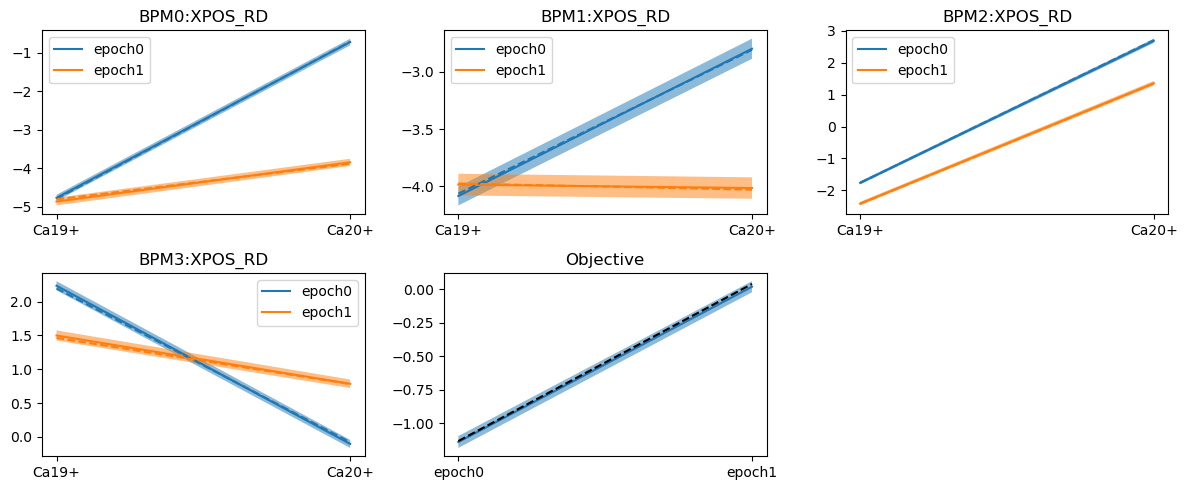

In [17]:
with capture_warnings():
    fig,ax = plot_msGP_over_states(
        msbo.msGP,
        control_values=control_values,
        control_data_labels = ["epoch0","epoch1"],
        state_names = state_names,
        objective_PVs = objective_PVs,
        multi_state_objective_fn = multi_state_objective_fn,
        CL = 3,
    )

    l_ytrue = np.zeros((len(control_values),n_state,n_obj))
    l_obj = np.zeros(len(control_values))

    for i,x in enumerate(control_values):
        for istate in range(n_state):
            future = msbo.evaluator.submit(x,istate=istate)
            df, df_ramp  = msbo.evaluator.get_result(future)
            y = df[objective_PVs].mean().values
            l_ytrue[i,istate,:] = y
        l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

    for i_obj in range(n_obj):
        for i_c in range(len(control_values)):
            ax[i_obj].plot(np.arange(n_state),l_ytrue[i_c,:,i_obj],'--C'+str(i_c))
    ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

# 2nd globalBO

In [18]:
with capture_warnings():
    msbo.optimize_global(neval=n_eval, beta=beta)
    candidate = msbo.query_candidate(msbo.control_bounds_botorch, beta=0.0)
    control_values = np.vstack((control_values,candidate))

_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 1.0
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:09.580281,1.0,0.463001,-16.0,0.5,0.5,1.0,1.000574,0.463526,-15.999825,0.500537,0.500271,1.000233,-3.964292,-1.520925,-1.483265,2.160374,Ca19+
2025-01-30 14:47:09.780281,1.0,0.463001,-16.0,0.5,0.5,1.0,1.000304,0.463096,-15.999067,0.500666,0.500678,1.000845,-3.965998,-1.524625,-1.482456,2.162219,Ca19+
2025-01-30 14:47:09.980281,1.0,0.463001,-16.0,0.5,0.5,1.0,1.000890,0.463294,-15.999392,0.500209,0.500329,1.000131,-3.963089,-1.522054,-1.483942,2.161553,Ca19+
2025-01-30 14:47:10.180281,1.0,0.463001,-16.0,0.5,0.5,1.0,1.000662,0.463700,-15.999573,0.500415,0.500587,1.000077,-3.963406,-1.521475,-1.483947,2.160451,Ca19+
2025-01-30 14:47:10.380281,1.0,0.463001,-16.0,0.5,0.5,1.0,1.000126,0.463341,-15.999768,0.500131,0.500228,1.000599,-3.965879,-1.521939,-1.483446,2.162177,Ca19+
2025-01-30 14:47:10.580281,1.0,0.463001,-16.0,0.5,0.5,1.0,1.000408,0.463570,-15.999531,0.500180,0.500630,1.000446,-3.964694,-1.522004,-1.483963,2.161775,Ca19+
2025-01-30 14:47:10.780281,1.0,0.463001,-16.0,0.5,0.5,1.0,1.000784,0.463256,-15.999231,0.500562,0.500973,1.000385,-3.964042,-1.523270,-1.483589,2.161855,Ca19+
2025-01-30 14:47:10.980281,1.0,0.463001,-16.0,0.5,0.5,1.0,1.000517,0.463454,-15.999713,0.500956,0.500242,1.000193,-3.964465,-1.521822,-1.482432,2.159522,Ca19+
2025-01-30 14:47:11.180281,1.0,0.463001,-16.0,0.5,0.5,1.0,1.000628,0.463541,-15.999327,0.500187,0.500256,1.000464,-3.964098,-1.521912,-1.483572,2.161341,Ca19+
2025-01-30 14:47:11.380281,1.0,0.463001,-16.0,0.5,0.5,1.0,1.000527,0.463003,-15.999523,0.500383,0.500658,1.000749,-3.965677,-1.522784,-1.483215,2.162903,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:11.580281,1.0,0.463001,-16.0,0.5,0.5,1.0,1.000625,0.463717,-15.999689,0.500117,0.500465,1.000011,-3.963249,-1.520986,-1.484469,2.160906,Ca19+
2025-01-30 14:47:11.780281,1.0,0.463001,-16.0,0.5,0.5,1.0,1.000870,0.463854,-15.999834,0.500133,0.500123,1.000222,-3.963240,-1.519162,-1.484054,2.160270,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.5994868014068337
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:11.980281,0.599487,1.0,-16.0,0.299743,0.299743,0.599487,0.600277,1.000413,-15.999180,0.300060,0.299929,0.599807,-4.538868,-3.510642,-2.387860,1.328656,Ca19+
2025-01-30 14:47:12.180281,0.599487,1.0,-16.0,0.299743,0.299743,0.599487,0.599513,1.000991,-15.999350,0.299940,0.299817,0.600130,-4.541758,-3.512822,-2.389021,1.330068,Ca19+
2025-01-30 14:47:12.380281,0.599487,1.0,-16.0,0.299743,0.299743,0.599487,0.599558,1.000149,-15.999948,0.300260,0.299994,0.599680,-4.537922,-3.507964,-2.388135,1.328923,Ca19+
2025-01-30 14:47:12.580281,0.599487,1.0,-16.0,0.299743,0.299743,0.599487,0.600087,1.000795,-15.999920,0.299967,0.300523,0.599990,-4.535888,-3.504999,-2.389686,1.326701,Ca19+
2025-01-30 14:47:12.780281,0.599487,1.0,-16.0,0.299743,0.299743,0.599487,0.599591,1.000851,-15.999698,0.300108,0.300500,0.599747,-4.538556,-3.509566,-2.389892,1.327703,Ca19+
2025-01-30 14:47:12.980281,0.599487,1.0,-16.0,0.299743,0.299743,0.599487,0.599816,1.000182,-15.999498,0.300139,0.300092,0.600104,-4.538651,-3.509177,-2.388107,1.329224,Ca19+
2025-01-30 14:47:13.180281,0.599487,1.0,-16.0,0.299743,0.299743,0.599487,0.600207,1.000861,-15.999373,0.299785,0.299767,0.599873,-4.539232,-3.510084,-2.388544,1.328640,Ca19+
2025-01-30 14:47:13.380281,0.599487,1.0,-16.0,0.299743,0.299743,0.599487,0.600363,1.000698,-15.999697,0.300657,0.300008,0.599515,-4.536557,-3.506783,-2.387687,1.327185,Ca19+
2025-01-30 14:47:13.580281,0.599487,1.0,-16.0,0.299743,0.299743,0.599487,0.599646,1.000581,-15.999498,0.300572,0.300155,0.599991,-4.539447,-3.510249,-2.388271,1.329056,Ca19+
2025-01-30 14:47:13.780281,0.599487,1.0,-16.0,0.299743,0.299743,0.599487,0.600258,1.000807,-15.999543,0.300041,0.300646,0.600125,-4.536514,-3.506582,-2.389570,1.326744,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:13.980281,0.599487,1.0,-16.0,0.299743,0.299743,0.599487,0.599706,1.000822,-15.999770,0.300724,0.299860,0.599806,-4.538988,-3.508839,-2.387927,1.328874,Ca19+
2025-01-30 14:47:14.180281,0.599487,1.0,-16.0,0.299743,0.299743,0.599487,0.599505,1.000056,-15.999007,0.300611,0.300728,0.600406,-4.540135,-3.512439,-2.388464,1.329513,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.2963270000685044
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:14.380281,0.296327,1.0,-16.0,0.148164,0.148164,0.296327,0.297255,1.000410,-15.999222,0.149139,0.148706,0.296453,-5.137119,-4.705230,-2.353074,2.068598,Ca19+
2025-01-30 14:47:14.580281,0.296327,1.0,-16.0,0.148164,0.148164,0.296327,0.296960,1.000719,-15.999604,0.148226,0.148188,0.297317,-5.139924,-4.705182,-2.354631,2.069044,Ca19+
2025-01-30 14:47:14.780281,0.296327,1.0,-16.0,0.148164,0.148164,0.296327,0.296605,1.000574,-15.999754,0.149068,0.148842,0.296607,-5.138077,-4.705149,-2.355247,2.068937,Ca19+
2025-01-30 14:47:14.980281,0.296327,1.0,-16.0,0.148164,0.148164,0.296327,0.297241,1.000139,-15.999550,0.148651,0.148935,0.297116,-5.137254,-4.705232,-2.355002,2.067869,Ca19+
2025-01-30 14:47:15.180281,0.296327,1.0,-16.0,0.148164,0.148164,0.296327,0.297315,1.000199,-15.999790,0.148779,0.148948,0.296810,-5.136145,-4.704496,-2.355085,2.067327,Ca19+
2025-01-30 14:47:15.380281,0.296327,1.0,-16.0,0.148164,0.148164,0.296327,0.296692,1.000393,-15.999783,0.148892,0.148303,0.297150,-5.139693,-4.704845,-2.354493,2.069700,Ca19+
2025-01-30 14:47:15.580281,0.296327,1.0,-16.0,0.148164,0.148164,0.296327,0.296837,1.000725,-15.999094,0.149005,0.149075,0.297160,-5.139934,-4.706681,-2.354993,2.068951,Ca19+
2025-01-30 14:47:15.780281,0.296327,1.0,-16.0,0.148164,0.148164,0.296327,0.296908,1.000472,-15.999267,0.148951,0.148747,0.296822,-5.138608,-4.705826,-2.354075,2.069154,Ca19+
2025-01-30 14:47:15.980281,0.296327,1.0,-16.0,0.148164,0.148164,0.296327,0.296752,1.000688,-15.999375,0.148173,0.148341,0.296878,-5.139068,-4.705824,-2.354369,2.069472,Ca19+
2025-01-30 14:47:16.180281,0.296327,1.0,-16.0,0.148164,0.148164,0.296327,0.296448,1.000233,-15.999763,0.148262,0.148576,0.296667,-5.137498,-4.705403,-2.355278,2.069513,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:16.380281,0.296327,1.0,-16.0,0.148164,0.148164,0.296327,0.296367,1.000596,-15.999489,0.148965,0.148654,0.297308,-5.141065,-4.706163,-2.355241,2.070182,Ca19+
2025-01-30 14:47:16.580281,0.296327,1.0,-16.0,0.148164,0.148164,0.296327,0.297123,1.000678,-15.999893,0.148363,0.149116,0.297132,-5.137407,-4.705015,-2.356821,2.066875,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.5421360750999055
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:16.780281,0.542136,1.0,-16.0,0.271068,0.271068,0.542136,0.542536,1.000887,-15.999921,0.271601,0.271220,0.542935,-4.781181,-3.921464,-2.418839,1.445046,Ca19+
2025-01-30 14:47:16.980281,0.542136,1.0,-16.0,0.271068,0.271068,0.542136,0.542520,1.000158,-15.999654,0.271515,0.271273,0.542139,-4.780915,-3.924217,-2.418020,1.445020,Ca19+
2025-01-30 14:47:17.180281,0.542136,1.0,-16.0,0.271068,0.271068,0.542136,0.542193,1.000541,-15.999751,0.271420,0.271957,0.542804,-4.781082,-3.923431,-2.420148,1.444426,Ca19+
2025-01-30 14:47:17.380281,0.542136,1.0,-16.0,0.271068,0.271068,0.542136,0.542872,1.000837,-15.999338,0.271738,0.271957,0.543083,-4.780796,-3.923077,-2.419374,1.443705,Ca19+
2025-01-30 14:47:17.580281,0.542136,1.0,-16.0,0.271068,0.271068,0.542136,0.542949,1.000455,-15.999540,0.272014,0.271766,0.542274,-4.779345,-3.922547,-2.418282,1.443293,Ca19+
2025-01-30 14:47:17.780281,0.542136,1.0,-16.0,0.271068,0.271068,0.542136,0.542451,1.000029,-15.999592,0.271885,0.271684,0.542153,-4.780393,-3.924184,-2.418215,1.444550,Ca19+
2025-01-30 14:47:17.980281,0.542136,1.0,-16.0,0.271068,0.271068,0.542136,0.542302,1.000022,-15.999761,0.271883,0.271270,0.542172,-4.781044,-3.923926,-2.417678,1.445557,Ca19+
2025-01-30 14:47:18.180281,0.542136,1.0,-16.0,0.271068,0.271068,0.542136,0.542599,1.000906,-15.999675,0.271413,0.271381,0.542577,-4.781457,-3.923549,-2.419137,1.444510,Ca19+
2025-01-30 14:47:18.380281,0.542136,1.0,-16.0,0.271068,0.271068,0.542136,0.542848,1.000263,-15.999410,0.271475,0.271488,0.543048,-4.780855,-3.922859,-2.418265,1.444907,Ca19+
2025-01-30 14:47:18.580281,0.542136,1.0,-16.0,0.271068,0.271068,0.542136,0.542414,1.000218,-15.999594,0.271312,0.271491,0.542792,-4.781448,-3.923855,-2.418822,1.445323,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:18.780281,0.542136,1.0,-16.0,0.271068,0.271068,0.542136,0.542345,1.000143,-15.999110,0.271290,0.272018,0.542441,-4.782189,-3.927560,-2.419443,1.444688,Ca19+
2025-01-30 14:47:18.980281,0.542136,1.0,-16.0,0.271068,0.271068,0.542136,0.542759,1.000371,-15.999158,0.271252,0.271596,0.543123,-4.782041,-3.924929,-2.418757,1.445126,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.6292028147446594
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:19.180281,0.629203,0.84542,16.0,0.314601,0.314601,0.629203,0.629754,0.845492,16.000031,0.315007,0.315426,0.629625,-3.657419,-4.547067,1.515640,0.464648,Ca20+
2025-01-30 14:47:19.380281,0.629203,0.84542,16.0,0.314601,0.314601,0.629203,0.629310,0.845595,16.000874,0.315231,0.315008,0.630198,-3.664902,-4.545008,1.515427,0.472300,Ca20+
2025-01-30 14:47:19.580281,0.629203,0.84542,16.0,0.314601,0.314601,0.629203,0.629665,0.845555,16.000547,0.314969,0.315532,0.629952,-3.659432,-4.547085,1.515070,0.465886,Ca20+
2025-01-30 14:47:19.780281,0.629203,0.84542,16.0,0.314601,0.314601,0.629203,0.629392,0.846094,16.000240,0.315494,0.315019,0.629541,-3.663686,-4.545125,1.515230,0.471144,Ca20+
2025-01-30 14:47:19.980281,0.629203,0.84542,16.0,0.314601,0.314601,0.629203,0.629960,0.846131,16.000152,0.315045,0.315552,0.629226,-3.656717,-4.547324,1.514976,0.463701,Ca20+
2025-01-30 14:47:20.180281,0.629203,0.84542,16.0,0.314601,0.314601,0.629203,0.630120,0.845627,16.000332,0.314892,0.315480,0.629634,-3.656325,-4.547636,1.515544,0.463576,Ca20+
2025-01-30 14:47:20.380281,0.629203,0.84542,16.0,0.314601,0.314601,0.629203,0.629671,0.846005,16.000583,0.314977,0.315475,0.629552,-3.659026,-4.546522,1.514912,0.466067,Ca20+
2025-01-30 14:47:20.580281,0.629203,0.84542,16.0,0.314601,0.314601,0.629203,0.629443,0.845778,16.000903,0.315136,0.315507,0.629579,-3.659540,-4.545779,1.515127,0.467875,Ca20+
2025-01-30 14:47:20.780281,0.629203,0.84542,16.0,0.314601,0.314601,0.629203,0.629741,0.846223,16.000704,0.314999,0.314642,0.629723,-3.663493,-4.544640,1.515735,0.471448,Ca20+
2025-01-30 14:47:20.980281,0.629203,0.84542,16.0,0.314601,0.314601,0.629203,0.630162,0.845524,16.000705,0.314993,0.314743,0.629308,-3.656689,-4.544913,1.517303,0.468385,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:21.180281,0.629203,0.84542,16.0,0.314601,0.314601,0.629203,0.629567,0.846388,16.000048,0.315087,0.315161,0.629309,-3.660801,-4.545871,1.514923,0.467371,Ca20+
2025-01-30 14:47:21.380281,0.629203,0.84542,16.0,0.314601,0.314601,0.629203,0.629973,0.845994,16.000833,0.315592,0.315259,0.629641,-3.661887,-4.546287,1.515191,0.469999,Ca20+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.5361726718595596
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:21.580281,0.536173,1.0,16.0,0.268086,0.268086,0.536173,0.536874,1.000663,16.000754,0.268531,0.268255,0.536852,-3.897798,-4.042302,1.348713,0.777121,Ca20+
2025-01-30 14:47:21.780281,0.536173,1.0,16.0,0.268086,0.268086,0.536173,0.537007,1.000918,16.000081,0.268468,0.268889,0.536376,-3.893699,-4.045852,1.348377,0.770515,Ca20+
2025-01-30 14:47:21.980281,0.536173,1.0,16.0,0.268086,0.268086,0.536173,0.536533,1.000762,16.000145,0.268898,0.268274,0.537025,-3.902572,-4.043103,1.347782,0.778468,Ca20+
2025-01-30 14:47:22.180281,0.536173,1.0,16.0,0.268086,0.268086,0.536173,0.536701,1.000335,16.000561,0.268295,0.268558,0.536297,-3.891080,-4.042720,1.349873,0.773045,Ca20+
2025-01-30 14:47:22.380281,0.536173,1.0,16.0,0.268086,0.268086,0.536173,0.536464,1.000854,16.000752,0.268676,0.268252,0.536289,-3.896415,-4.040067,1.348526,0.778190,Ca20+
2025-01-30 14:47:22.580281,0.536173,1.0,16.0,0.268086,0.268086,0.536173,0.537113,1.000859,16.000248,0.268647,0.268843,0.536645,-3.895966,-4.046010,1.348150,0.772122,Ca20+
2025-01-30 14:47:22.780281,0.536173,1.0,16.0,0.268086,0.268086,0.536173,0.536243,1.000984,16.000725,0.268396,0.268480,0.536402,-3.896665,-4.040670,1.347663,0.776255,Ca20+
2025-01-30 14:47:22.980281,0.536173,1.0,16.0,0.268086,0.268086,0.536173,0.536254,1.000471,16.000117,0.268246,0.268635,0.536971,-3.897831,-4.044069,1.348110,0.773515,Ca20+
2025-01-30 14:47:23.180281,0.536173,1.0,16.0,0.268086,0.268086,0.536173,0.537091,1.000466,16.000023,0.268194,0.269074,0.536546,-3.891007,-4.047523,1.349203,0.767612,Ca20+
2025-01-30 14:47:23.380281,0.536173,1.0,16.0,0.268086,0.268086,0.536173,0.536198,1.000759,16.000974,0.268319,0.269028,0.536567,-3.895312,-4.042563,1.347113,0.773314,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:23.580281,0.536173,1.0,16.0,0.268086,0.268086,0.536173,0.537167,1.000546,16.000338,0.268640,0.268887,0.536396,-3.892400,-4.045808,1.349217,0.771264,Ca20+
2025-01-30 14:47:23.780281,0.536173,1.0,16.0,0.268086,0.268086,0.536173,0.537108,1.000572,16.000192,0.268888,0.268468,0.536388,-3.894819,-4.044242,1.349563,0.774789,Ca20+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 1.0
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:23.980281,1.0,1.0,16.0,0.5,0.5,1.0,1.000102,1.000865,16.000960,0.500841,0.500505,1.000360,-4.293094,-5.476224,0.831870,0.286938,Ca20+
2025-01-30 14:47:24.180281,1.0,1.0,16.0,0.5,0.5,1.0,1.000707,1.000676,16.000133,0.500973,0.500022,1.000206,-4.291057,-5.475969,0.831568,0.286914,Ca20+
2025-01-30 14:47:24.380281,1.0,1.0,16.0,0.5,0.5,1.0,1.000644,1.000814,16.000629,0.500337,0.500513,1.000775,-4.290304,-5.476291,0.831375,0.285655,Ca20+
2025-01-30 14:47:24.580281,1.0,1.0,16.0,0.5,0.5,1.0,1.000733,1.000919,16.000279,0.500752,0.500076,1.000829,-4.292777,-5.476314,0.831143,0.287660,Ca20+
2025-01-30 14:47:24.780281,1.0,1.0,16.0,0.5,0.5,1.0,1.000979,1.000647,16.000069,0.500587,0.500992,1.000189,-4.285181,-5.476233,0.831257,0.282651,Ca20+
2025-01-30 14:47:24.980281,1.0,1.0,16.0,0.5,0.5,1.0,1.000656,1.000731,16.000473,0.500745,0.500138,1.000327,-4.291092,-5.476083,0.831609,0.286683,Ca20+
2025-01-30 14:47:25.180281,1.0,1.0,16.0,0.5,0.5,1.0,1.000621,1.000481,16.000542,0.500022,0.500378,1.000713,-4.288782,-5.475881,0.831738,0.285012,Ca20+
2025-01-30 14:47:25.380281,1.0,1.0,16.0,0.5,0.5,1.0,1.000859,1.000636,16.000809,0.500200,0.500066,1.000093,-4.288597,-5.475842,0.831866,0.285361,Ca20+
2025-01-30 14:47:25.580281,1.0,1.0,16.0,0.5,0.5,1.0,1.000565,1.000675,16.000260,0.500018,0.500314,1.000446,-4.288720,-5.475507,0.831686,0.284724,Ca20+
2025-01-30 14:47:25.780281,1.0,1.0,16.0,0.5,0.5,1.0,1.000341,1.000221,16.000897,0.500030,0.500819,1.000845,-4.288214,-5.476140,0.832048,0.284285,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:25.980281,1.0,1.0,16.0,0.5,0.5,1.0,1.000211,1.000540,16.000575,0.500146,0.500727,1.000587,-4.289204,-5.475781,0.831916,0.284496,Ca20+
2025-01-30 14:47:26.180281,1.0,1.0,16.0,0.5,0.5,1.0,1.000096,1.000045,16.000129,0.500681,0.500980,1.000703,-4.288472,-5.475982,0.832044,0.284358,Ca20+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.6521412259468035
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:26.380281,0.652141,0.0,16.0,0.326071,0.326071,0.652141,0.652911,0.000026,16.000135,0.326382,0.326952,0.652165,-1.793775,-3.604360,1.831942,-0.329976,Ca20+
2025-01-30 14:47:26.580281,0.652141,0.0,16.0,0.326071,0.326071,0.652141,0.652769,0.000876,16.000174,0.326522,0.326914,0.652497,-1.796943,-3.606159,1.832370,-0.327049,Ca20+
2025-01-30 14:47:26.780281,0.652141,0.0,16.0,0.326071,0.326071,0.652141,0.652387,0.000590,16.000713,0.326520,0.326328,0.653112,-1.799556,-3.604707,1.834816,-0.322056,Ca20+
2025-01-30 14:47:26.980281,0.652141,0.0,16.0,0.326071,0.326071,0.652141,0.653078,0.000530,16.000426,0.326870,0.326075,0.652750,-1.800753,-3.604792,1.833146,-0.322333,Ca20+
2025-01-30 14:47:27.180281,0.652141,0.0,16.0,0.326071,0.326071,0.652141,0.653120,0.000232,16.000835,0.326427,0.326186,0.652352,-1.795253,-3.603518,1.834248,-0.326287,Ca20+
2025-01-30 14:47:27.380281,0.652141,0.0,16.0,0.326071,0.326071,0.652141,0.652419,0.000610,16.000645,0.326884,0.327004,0.652597,-1.796976,-3.605318,1.833871,-0.324408,Ca20+
2025-01-30 14:47:27.580281,0.652141,0.0,16.0,0.326071,0.326071,0.652141,0.652379,0.000471,16.000631,0.326688,0.326466,0.652692,-1.797523,-3.603712,1.835021,-0.323010,Ca20+
2025-01-30 14:47:27.780281,0.652141,0.0,16.0,0.326071,0.326071,0.652141,0.652784,0.000574,16.000699,0.326841,0.326147,0.652294,-1.796796,-3.602923,1.835340,-0.323021,Ca20+
2025-01-30 14:47:27.980281,0.652141,0.0,16.0,0.326071,0.326071,0.652141,0.652194,0.000465,16.000402,0.326818,0.326579,0.652908,-1.799412,-3.604191,1.834461,-0.321818,Ca20+
2025-01-30 14:47:28.180281,0.652141,0.0,16.0,0.326071,0.326071,0.652141,0.652677,0.000686,16.000259,0.326295,0.326151,0.652537,-1.797083,-3.603522,1.834490,-0.324909,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:28.380281,0.652141,0.0,16.0,0.326071,0.326071,0.652141,0.652521,0.000661,16.000998,0.326922,0.326412,0.652610,-1.797589,-3.603985,1.835636,-0.321907,Ca20+
2025-01-30 14:47:28.580281,0.652141,0.0,16.0,0.326071,0.326071,0.652141,0.652222,0.000441,16.000849,0.326139,0.326111,0.652461,-1.793842,-3.601484,1.837306,-0.324462,Ca20+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.4717584213607052
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:28.780281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472306,0.304672,-15.999185,0.236091,0.236776,0.472022,-4.798266,-4.066641,-1.762292,2.193091,Ca19+
2025-01-30 14:47:28.980281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471873,0.304694,-15.999293,0.236524,0.236425,0.471759,-4.798263,-4.066574,-1.761509,2.193717,Ca19+
2025-01-30 14:47:29.180281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471877,0.304695,-15.999753,0.236814,0.236185,0.472067,-4.798683,-4.063988,-1.762216,2.193795,Ca19+
2025-01-30 14:47:29.380281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472589,0.305002,-15.999590,0.236750,0.235926,0.472475,-4.798062,-4.061728,-1.761759,2.193161,Ca19+
2025-01-30 14:47:29.580281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472370,0.304666,-15.999683,0.235960,0.236803,0.472616,-4.799701,-4.064358,-1.764349,2.193161,Ca19+
2025-01-30 14:47:29.780281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472181,0.304658,-15.999188,0.236558,0.236640,0.472171,-4.798871,-4.065977,-1.761990,2.193318,Ca19+
2025-01-30 14:47:29.980281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471790,0.304502,-15.999264,0.236364,0.236055,0.471975,-4.799506,-4.066053,-1.761319,2.194828,Ca19+
2025-01-30 14:47:30.180281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472335,0.304547,-15.999163,0.236127,0.236683,0.472102,-4.798535,-4.066336,-1.762079,2.193346,Ca19+
2025-01-30 14:47:30.380281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472748,0.304596,-15.999220,0.236528,0.235943,0.472428,-4.798180,-4.062883,-1.760763,2.193616,Ca19+
2025-01-30 14:47:30.580281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472413,0.305196,-15.999108,0.236755,0.236396,0.472240,-4.798113,-4.064791,-1.761544,2.192742,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:30.780281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471836,0.304620,-15.999619,0.236019,0.236114,0.472531,-4.801065,-4.064559,-1.763417,2.194962,Ca19+
2025-01-30 14:47:30.980281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472323,0.304712,-15.999311,0.236277,0.236820,0.472361,-4.799118,-4.065637,-1.763012,2.193025,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.4717584213607052
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:31.180281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472442,0.304662,16.000668,0.236809,0.236561,0.471993,-0.717039,-2.807531,2.709194,-0.075889,Ca20+
2025-01-30 14:47:31.380281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472718,0.304621,16.000734,0.235948,0.236551,0.472059,-0.713851,-2.808219,2.709394,-0.080604,Ca20+
2025-01-30 14:47:31.580281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472672,0.304603,16.000413,0.236354,0.236272,0.472448,-0.719412,-2.808985,2.708464,-0.076607,Ca20+
2025-01-30 14:47:31.780281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472084,0.304438,16.000409,0.236674,0.236297,0.472102,-0.717308,-2.805797,2.709753,-0.074976,Ca20+
2025-01-30 14:47:31.980281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472215,0.305041,16.000673,0.236828,0.235956,0.472339,-0.721384,-2.807241,2.709342,-0.071267,Ca20+
2025-01-30 14:47:32.180281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.471937,0.305027,16.000790,0.236046,0.236348,0.472238,-0.716670,-2.806885,2.709640,-0.075960,Ca20+
2025-01-30 14:47:32.380281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472377,0.304651,16.000928,0.236822,0.235944,0.471877,-0.716082,-2.804958,2.711061,-0.073585,Ca20+
2025-01-30 14:47:32.580281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472322,0.304372,16.000211,0.236773,0.236824,0.472110,-0.717634,-2.808032,2.708269,-0.077300,Ca20+
2025-01-30 14:47:32.780281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.471783,0.304689,16.000457,0.236811,0.236115,0.472395,-0.720887,-2.806008,2.709396,-0.071389,Ca20+
2025-01-30 14:47:32.980281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472631,0.304570,16.000581,0.236876,0.236454,0.472488,-0.721289,-2.809446,2.708017,-0.074266,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:33.180281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472486,0.304629,16.000958,0.236066,0.236375,0.472092,-0.714227,-2.807037,2.710078,-0.078379,Ca20+
2025-01-30 14:47:33.380281,0.471758,0.304286,16.0,0.235879,0.235879,0.471758,0.472436,0.304313,16.000056,0.236871,0.236281,0.472456,-0.721396,-2.808084,2.708224,-0.074337,Ca20+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.5342491585923642
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:33.580281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534467,1.000245,-15.999956,0.267521,0.267589,0.534876,-4.809762,-3.971985,-2.421394,1.462021,Ca19+
2025-01-30 14:47:33.780281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.535099,1.000623,-15.999655,0.267819,0.267925,0.534453,-4.808384,-3.972141,-2.421342,1.459868,Ca19+
2025-01-30 14:47:33.980281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534315,1.000238,-15.999841,0.267769,0.267179,0.534443,-4.811161,-3.974214,-2.420338,1.463093,Ca19+
2025-01-30 14:47:34.180281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534434,1.000363,-15.999752,0.268049,0.267320,0.534519,-4.810991,-3.974019,-2.420275,1.462735,Ca19+
2025-01-30 14:47:34.380281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534362,1.000741,-15.999883,0.267865,0.267336,0.534580,-4.811219,-3.973729,-2.421066,1.462455,Ca19+
2025-01-30 14:47:34.580281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534930,1.000101,-15.999374,0.268124,0.267647,0.534775,-4.809955,-3.973676,-2.419921,1.461863,Ca19+
2025-01-30 14:47:34.780281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534398,1.000785,-15.999687,0.267910,0.267378,0.534912,-4.811939,-3.974287,-2.421028,1.462815,Ca19+
2025-01-30 14:47:34.980281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534666,1.000393,-15.999973,0.267534,0.268019,0.534283,-4.808140,-3.971932,-2.422100,1.460067,Ca19+
2025-01-30 14:47:35.180281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534970,1.000757,-15.999540,0.267635,0.267668,0.534832,-4.810057,-3.973168,-2.421302,1.461031,Ca19+
2025-01-30 14:47:35.380281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534846,1.000311,-15.999586,0.268079,0.268091,0.535072,-4.809047,-3.971938,-2.421248,1.460923,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:35.580281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.534777,1.000006,-15.999637,0.267257,0.267551,0.534984,-4.809787,-3.972754,-2.420943,1.462009,Ca19+
2025-01-30 14:47:35.780281,0.534249,1.0,-16.0,0.267125,0.267125,0.534249,0.535150,1.000958,-15.999049,0.267399,0.267550,0.535215,-4.811906,-3.975482,-2.421169,1.461679,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.5342491585923642
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:35.980281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534782,1.000010,16.000793,0.268115,0.267927,0.535060,-3.886625,-4.032481,1.351032,0.779353,Ca20+
2025-01-30 14:47:36.180281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534800,1.000209,16.000047,0.267776,0.267675,0.534831,-3.885118,-4.032896,1.351715,0.777294,Ca20+
2025-01-30 14:47:36.380281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.535208,1.000220,16.000671,0.268104,0.267492,0.534268,-3.881398,-4.030641,1.352851,0.779594,Ca20+
2025-01-30 14:47:36.580281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534659,1.000156,16.000854,0.267447,0.268090,0.535079,-3.884199,-4.032797,1.350678,0.775835,Ca20+
2025-01-30 14:47:36.780281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534333,1.000440,16.000990,0.267288,0.267332,0.534444,-3.882543,-4.027317,1.351635,0.780160,Ca20+
2025-01-30 14:47:36.980281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534947,1.000771,16.000065,0.267314,0.268037,0.535181,-3.886754,-4.035201,1.349853,0.773581,Ca20+
2025-01-30 14:47:37.180281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534881,1.000260,16.000080,0.267137,0.267737,0.534400,-3.878702,-4.032642,1.352614,0.773191,Ca20+
2025-01-30 14:47:37.380281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534298,1.000512,16.000218,0.267339,0.267194,0.534643,-3.885429,-4.028850,1.351542,0.779829,Ca20+
2025-01-30 14:47:37.580281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534892,1.000195,16.000236,0.267543,0.267935,0.534911,-3.883575,-4.033939,1.351468,0.774937,Ca20+
2025-01-30 14:47:37.780281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534472,1.000926,16.000629,0.268026,0.267252,0.534877,-3.891410,-4.028617,1.349819,0.783957,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:37.980281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.534344,1.000819,16.000895,0.267703,0.267176,0.534883,-3.889831,-4.027465,1.350114,0.783784,Ca20+
2025-01-30 14:47:38.180281,0.534249,1.0,16.0,0.267125,0.267125,0.534249,0.535210,1.000961,16.000944,0.268114,0.267635,0.534367,-3.884996,-4.030408,1.350702,0.780206,Ca20+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.5357642314000656
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:38.380281,0.535764,1.0,-16.0,0.267882,0.267882,0.535764,0.535815,1.000101,-15.999883,0.268863,0.268459,0.536396,-4.804523,-3.962946,-2.420436,1.459180,Ca19+
2025-01-30 14:47:38.580281,0.535764,1.0,-16.0,0.267882,0.267882,0.535764,0.536567,1.000361,-15.999257,0.268610,0.268567,0.536013,-4.804301,-3.965204,-2.420179,1.457624,Ca19+
2025-01-30 14:47:38.780281,0.535764,1.0,-16.0,0.267882,0.267882,0.535764,0.536633,1.000297,-15.999528,0.267882,0.268160,0.536102,-4.803941,-3.963762,-2.420330,1.457897,Ca19+
2025-01-30 14:47:38.980281,0.535764,1.0,-16.0,0.267882,0.267882,0.535764,0.535876,1.000728,-15.999541,0.268630,0.268188,0.536511,-4.806877,-3.965657,-2.420627,1.459748,Ca19+
2025-01-30 14:47:39.180281,0.535764,1.0,-16.0,0.267882,0.267882,0.535764,0.535771,1.000081,-15.999773,0.268463,0.268784,0.536515,-4.804537,-3.963652,-2.421439,1.458704,Ca19+
2025-01-30 14:47:39.380281,0.535764,1.0,-16.0,0.267882,0.267882,0.535764,0.536485,1.000035,-15.999087,0.268476,0.268412,0.535853,-4.805010,-3.966879,-2.419633,1.458361,Ca19+
2025-01-30 14:47:39.580281,0.535764,1.0,-16.0,0.267882,0.267882,0.535764,0.535787,1.000802,-15.999389,0.268440,0.268839,0.536608,-4.806643,-3.966520,-2.422095,1.458705,Ca19+
2025-01-30 14:47:39.780281,0.535764,1.0,-16.0,0.267882,0.267882,0.535764,0.536092,1.000399,-15.999155,0.268559,0.268051,0.536624,-4.807496,-3.967093,-2.419714,1.460353,Ca19+
2025-01-30 14:47:39.980281,0.535764,1.0,-16.0,0.267882,0.267882,0.535764,0.536565,1.000090,-15.999634,0.268568,0.268705,0.536398,-4.802580,-3.961730,-2.420481,1.457308,Ca19+
2025-01-30 14:47:40.180281,0.535764,1.0,-16.0,0.267882,0.267882,0.535764,0.536541,1.000254,-15.999370,0.267999,0.268511,0.536532,-4.804289,-3.964019,-2.420817,1.457964,Ca19+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [-16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:40.380281,0.535764,1.0,-16.0,0.267882,0.267882,0.535764,0.536031,1.000991,-15.999167,0.268143,0.268083,0.536364,-4.808206,-3.968432,-2.420896,1.459706,Ca19+
2025-01-30 14:47:40.580281,0.535764,1.0,-16.0,0.267882,0.267882,0.535764,0.536382,1.000341,-15.999039,0.268431,0.268447,0.536509,-4.806133,-3.966693,-2.420210,1.458932,Ca19+


_apply_control_couplings_runtime: data["index"],x[data["index"]] 0 0.5357642314000656
add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:40.780281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.536551,1.000799,16.000806,0.268869,0.268331,0.536476,-3.898011,-4.040798,1.348244,0.778752,Ca20+
2025-01-30 14:47:40.980281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.536313,1.000765,16.000801,0.268636,0.267892,0.536632,-3.899579,-4.038771,1.348543,0.781132,Ca20+
2025-01-30 14:47:41.180281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.536131,1.000435,16.000564,0.268819,0.268100,0.535912,-3.893886,-4.038496,1.349832,0.779260,Ca20+
2025-01-30 14:47:41.380281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.536187,1.000486,16.000629,0.268036,0.268462,0.536229,-3.891718,-4.040681,1.349273,0.773904,Ca20+
2025-01-30 14:47:41.580281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.535828,1.000394,16.000984,0.268084,0.268749,0.536339,-3.892600,-4.040249,1.348364,0.774228,Ca20+
2025-01-30 14:47:41.780281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.536632,1.000200,16.000761,0.268377,0.268853,0.536058,-3.888552,-4.042845,1.349941,0.771816,Ca20+
2025-01-30 14:47:41.980281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.536680,1.000466,16.000041,0.268363,0.268568,0.536118,-3.890998,-4.043557,1.349918,0.771948,Ca20+
2025-01-30 14:47:42.180281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.536748,1.000253,16.000062,0.268136,0.268790,0.536275,-3.889415,-4.045005,1.350092,0.769452,Ca20+
2025-01-30 14:47:42.380281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.535991,1.000067,16.000179,0.267935,0.268219,0.536288,-3.891183,-4.040585,1.350456,0.774055,Ca20+
2025-01-30 14:47:42.580281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.536334,1.000086,16.000718,0.268454,0.268850,0.536194,-3.890335,-4.042419,1.349623,0.772947,Ca20+


add_state_column_to_df: self.state_CSETs, reads ['SLIT0:POS_CSET'] [16.]
add_state_column_to_df: self.state_names ['Ca19+', 'Ca20+']


,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD,state
2025-01-30 14:47:42.780281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.535882,1.000846,16.000071,0.268494,0.268090,0.535993,-3.895805,-4.039020,1.348831,0.777714,Ca20+
2025-01-30 14:47:42.980281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.536376,1.000426,16.000337,0.268096,0.268043,0.536036,-3.890835,-4.039876,1.350542,0.775224,Ca20+


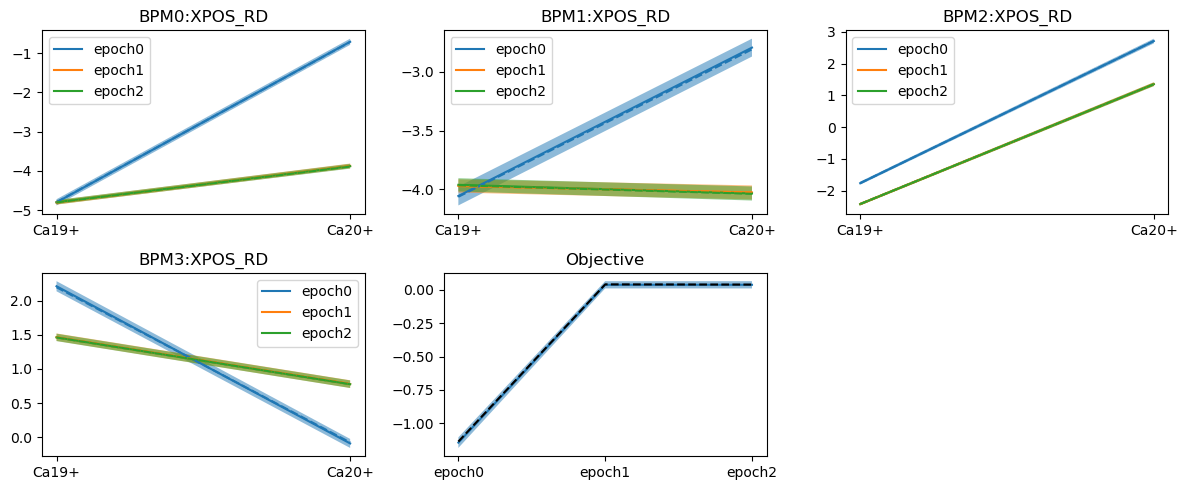

In [19]:
with capture_warnings():
    fig,ax = plot_msGP_over_states(
        msbo.msGP,
        control_values=control_values,
        control_data_labels = ["epoch0","epoch1","epoch2"],
        state_names = state_names,
        objective_PVs = objective_PVs,
        multi_state_objective_fn = multi_state_objective_fn,
        CL = 3,
    )

    l_ytrue = np.zeros((len(control_values),n_state,n_obj))
    l_obj = np.zeros(len(control_values))

    for i,x in enumerate(control_values):
        for istate in range(n_state):
            future = msbo.evaluator.submit(x,istate=istate)
            df, df_ramp  = msbo.evaluator.get_result(future)
            y = df[objective_PVs].mean().values
            l_ytrue[i,istate,:] = y
        l_obj[i] = multi_state_objective_fn(torch.tensor(l_ytrue[i,:,:])).item()

    for i_obj in range(n_obj):
        for i_c in range(len(control_values)):
            ax[i_obj].plot(np.arange(n_state),l_ytrue[i_c,:,i_obj],'--C'+str(i_c))
    ax[i_obj+1].plot(np.arange(len(control_values)),l_obj,'--k')

In [20]:
machineIO.history['df'].head()

,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD
2025-01-30 14:46:16.580281,0.471758,0.304286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-30 14:46:16.780281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.471773,0.304461,-15.999920,0.236449,0.236150,0.472141,-4.799428,-4.063990,-1.762888,2.194409
2025-01-30 14:46:16.980281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472209,0.305254,-15.999541,0.236744,0.236225,0.471806,-4.796764,-4.064243,-1.761595,2.192642
2025-01-30 14:46:17.180281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472571,0.304471,-15.999742,0.236586,0.235959,0.472659,-4.798988,-4.061399,-1.762187,2.193802
2025-01-30 14:46:17.380281,0.471758,0.304286,-16.0,0.235879,0.235879,0.471758,0.472004,0.305102,-15.999598,0.235969,0.236037,0.472267,-4.799456,-4.064401,-1.763046,2.194169


In [21]:
machineIO.history['df'].tail()

,PSC0:I_CSET,PSC1:I_CSET,SLIT0:POS_CSET,C0:I_CSET,C1:I_CSET,C2:I_CSET,PSC0:I_RD,PSC1:I_RD,SLIT0:POS_RD,C0:I_RD,C1:I_RD,C2:I_RD,BPM0:XPOS_RD,BPM1:XPOS_RD,BPM2:XPOS_RD,BPM3:XPOS_RD
2025-01-30 14:47:42.180281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.536748,1.000253,16.000062,0.268136,0.268790,0.536275,-3.889415,-4.045005,1.350092,0.769452
2025-01-30 14:47:42.380281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.535991,1.000067,16.000179,0.267935,0.268219,0.536288,-3.891183,-4.040585,1.350456,0.774055
2025-01-30 14:47:42.580281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.536334,1.000086,16.000718,0.268454,0.268850,0.536194,-3.890335,-4.042419,1.349623,0.772947
2025-01-30 14:47:42.780281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.535882,1.000846,16.000071,0.268494,0.268090,0.535993,-3.895805,-4.039020,1.348831,0.777714
2025-01-30 14:47:42.980281,0.535764,1.0,16.0,0.267882,0.267882,0.535764,0.536376,1.000426,16.000337,0.268096,0.268043,0.536036,-3.890835,-4.039876,1.350542,0.775224


In [22]:
msbo.msGP.l_train_X[0][:n_init]

tensor([[0.4721, 0.3047],
        [0.6011, 0.3693],
        [0.4203, 0.1372],
        [0.0531, 0.5695]], dtype=torch.float64)

In [23]:
msbo.msGP.l_train_X[0][n_init:n_init+n_eval]

tensor([[5.2891e-04, 1.0004e+00],
        [5.1339e-01, 1.0007e+00],
        [1.0003e+00, 7.8455e-04],
        [1.0007e+00, 1.0004e+00]], dtype=torch.float64)

In [24]:
msbo.msGP.l_train_X[0][n_init+n_eval:]

tensor([[1.0007, 0.4638],
        [0.5996, 1.0004],
        [0.2967, 1.0006],
        [0.5426, 1.0003]], dtype=torch.float64)